In [150]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler
from statsmodels.formula.api import ols

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
import statsmodels.api as sm
from scipy.stats import chi2_contingency, f_oneway

import datetime
import calendar
import math

cmap = cm.get_cmap('gnuplot')
pd.set_option('display.max_columns', None)


In [151]:
dataset = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/Fraud_Data.csv")
IP_table = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/IpAddress_to_Country.csv")

In [152]:
# train_upsampled = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/final_train_NI.csv")
# test = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/final_test_NI.csv")

In [153]:
# X_train_upsampled = train_upsampled.iloc[:,:len(train_upsampled.columns)-1]
# y_train_upsampled = train_upsampled.iloc[:,-1:]

# X_test = test.iloc[:,:len(test.columns)-1]
# y_test = test.iloc[:,-1:]

In [154]:
# scaler = StandardScaler() 
# stand = scaler.fit(X_train_upsampled)
# X_train_scaled = pd.DataFrame(stand.transform(X_train_upsampled), columns = X_train_upsampled.columns.tolist())
# X_test_scaled = pd.DataFrame(stand.transform(X_test), columns =  X_test.columns.tolist())

In [155]:
# dataset["time"] = pd.DataFrame(pd.to_datetime(dataset["purchase_time"]) - pd.to_datetime(dataset["signup_time"])).astype(str)
# dataset["time"] = dataset["time"].apply(lambda x : x[-8:])
# dataset["time"] = pd.to_datetime(dataset['time'],format= '%H:%M:%S' ).dt.time
# dataset["time"]

In [156]:
# device_duplicates = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
# device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           # hence we need to replace the "device_id" column name
# device_duplicates.reset_index(level=0, inplace= True)

## EDA

In [157]:
f_data = dataset[dataset["class"] == 1]
f_data

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
24,171711,2015-01-11 01:51:15,2015-01-11 01:51:16,52,YPLQGKBAAULUV,Direct,IE,F,35,1.120619e+09,1
25,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,SEO,FireFox,M,36,1.752167e+09,1
29,151705,2015-01-07 03:44:53,2015-01-07 03:44:54,48,URHCRIXOMLJMH,SEO,Chrome,F,27,2.836025e+09,1
59,345865,2015-02-01 05:59:23,2015-02-20 08:09:10,36,FKQPZUELCRKBL,SEO,IE,M,30,2.740590e+09,1
...,...,...,...,...,...,...,...,...,...,...,...
151082,305464,2015-01-07 09:06:55,2015-01-07 09:06:56,90,TVYSUZLTILQQN,SEO,IE,M,34,3.067794e+09,1
151099,115473,2015-01-01 07:26:14,2015-01-01 07:26:15,61,ZRHCEVZHNIBJH,Direct,IE,M,24,3.003296e+09,1
151103,5557,2015-01-04 23:03:04,2015-01-04 23:03:05,27,AWFGZTEHXMWEJ,Direct,Chrome,M,39,3.306999e+09,1
151104,252360,2015-01-04 09:40:44,2015-01-04 09:40:45,20,GSEYHMCBONPHK,Ads,IE,F,39,2.698870e+09,1


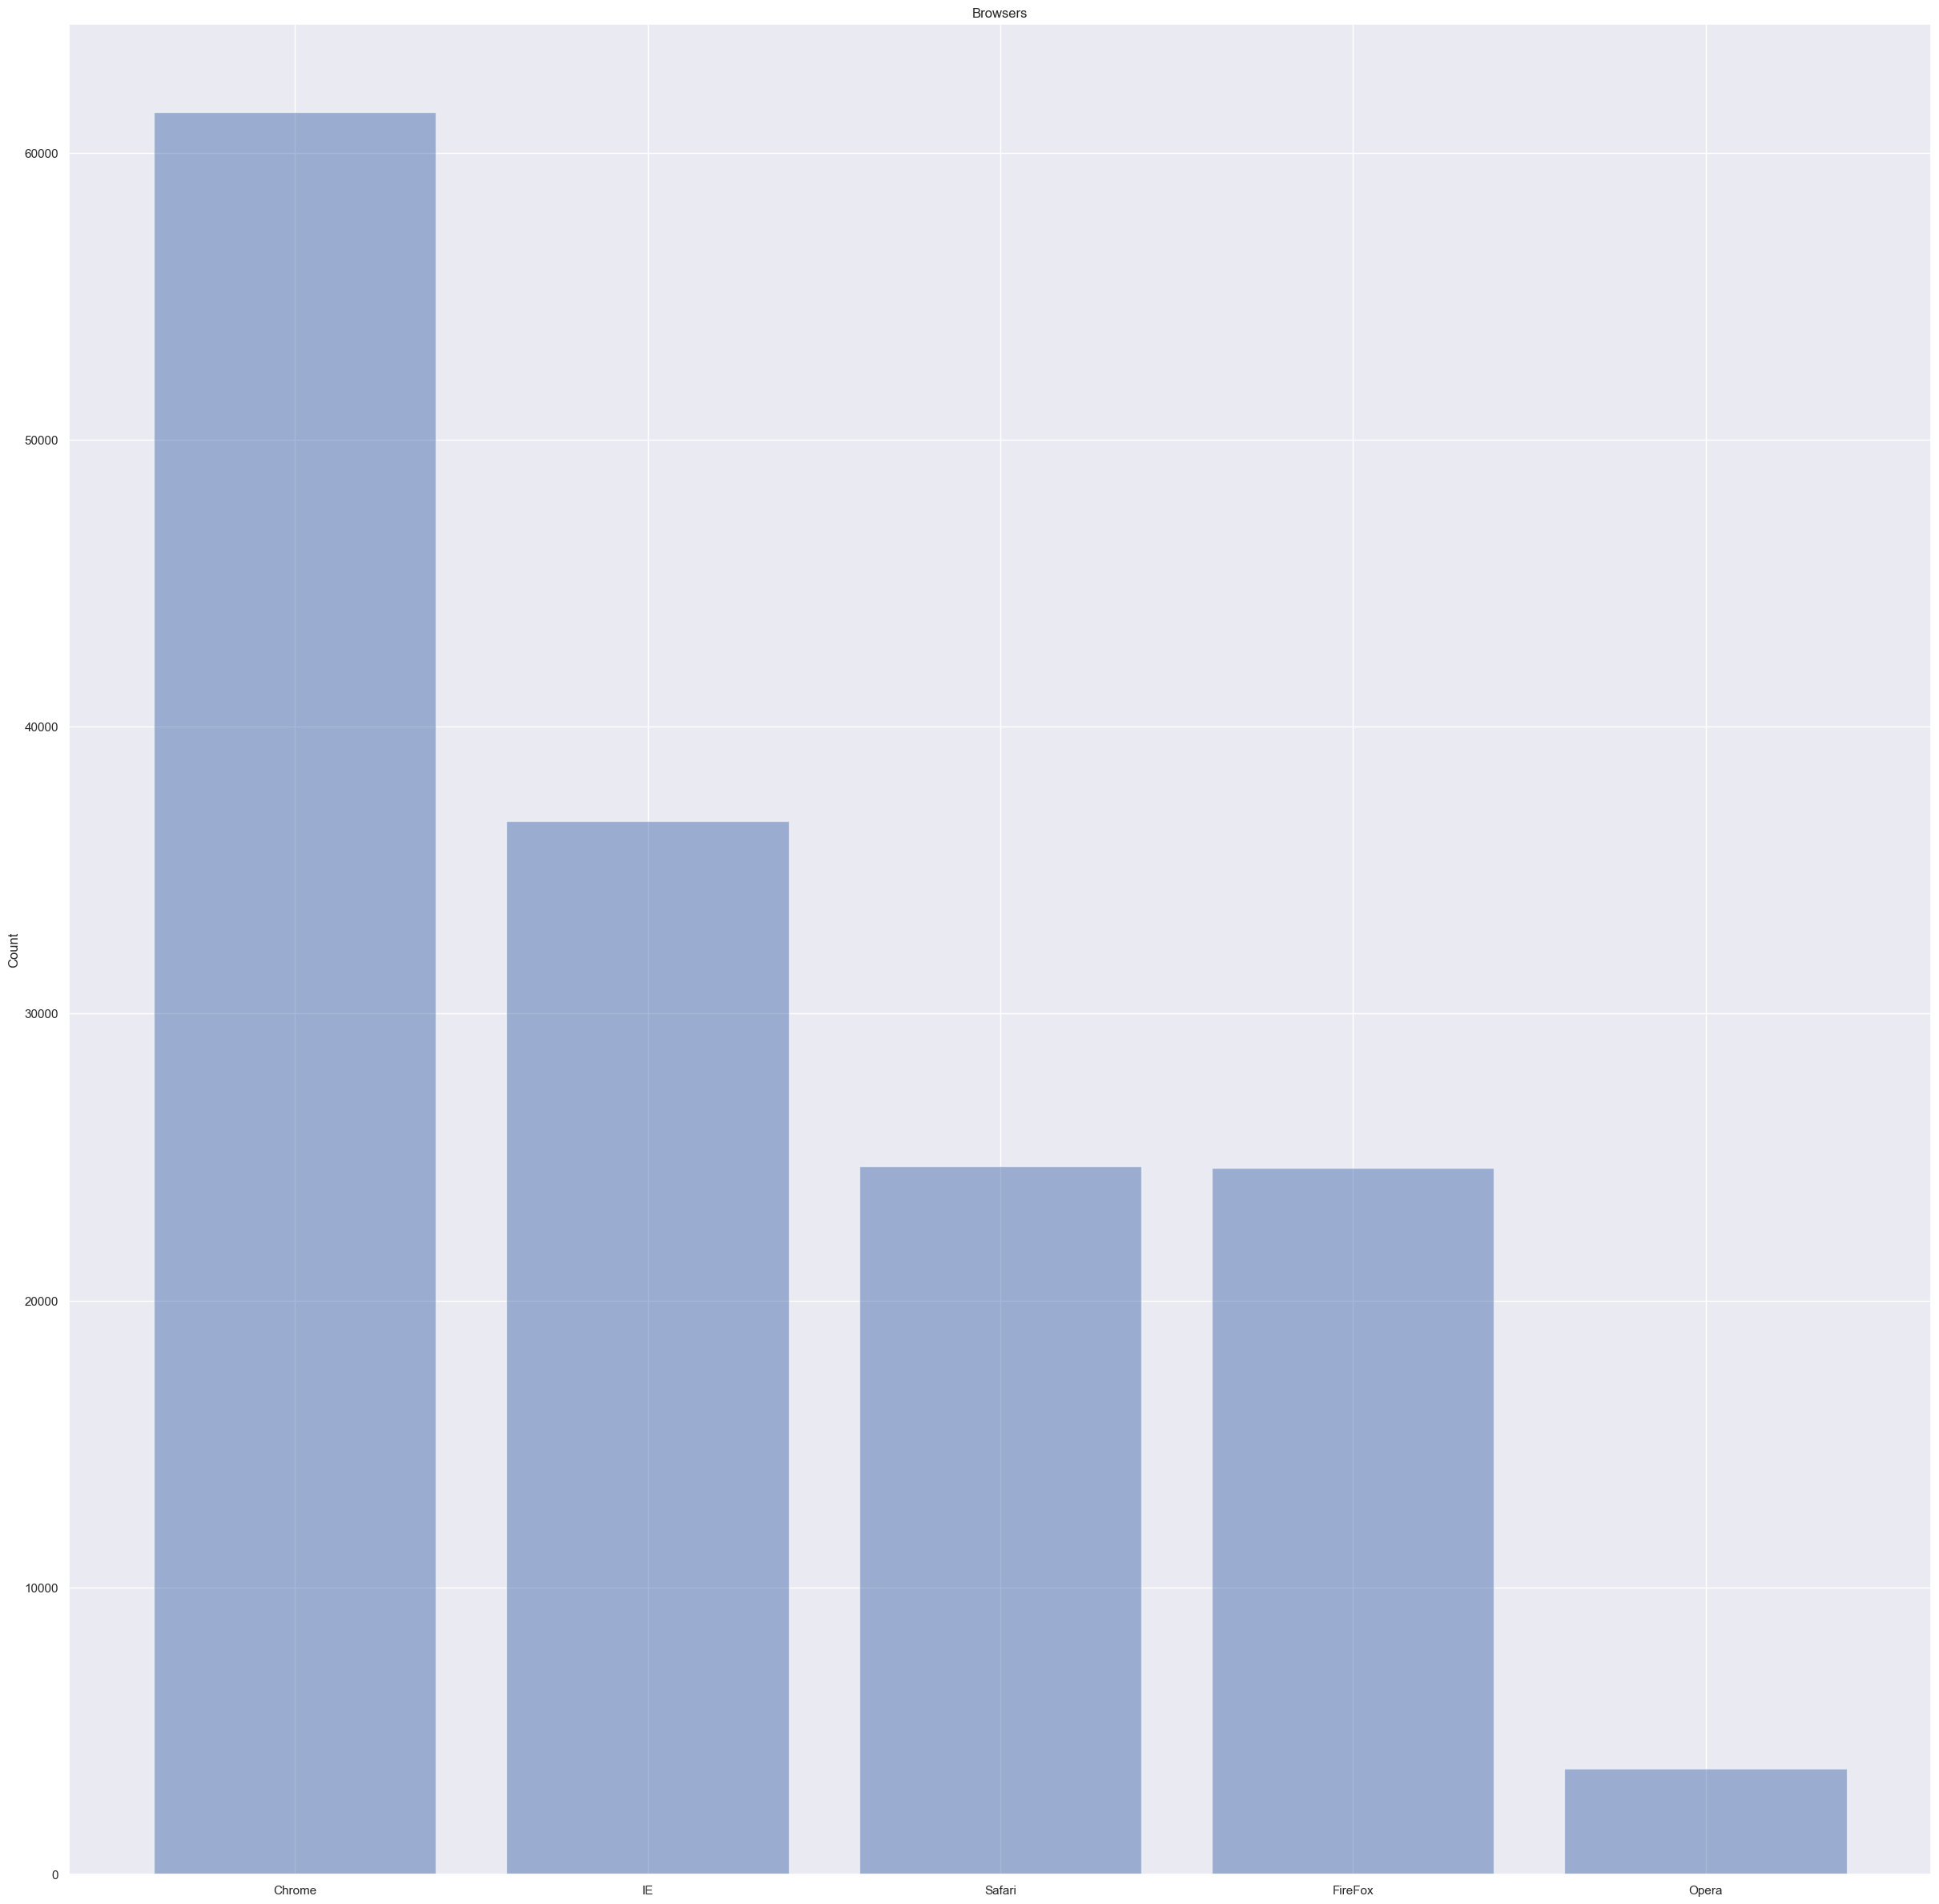

In [158]:
browsers = pd.DataFrame(dataset.browser.value_counts()).reset_index()
browsers.columns = ["Browser","Count"]
plt.bar(browsers.Browser, browsers.Count, align='center', alpha=0.5)
plt.ylabel('Count')
plt.title('Browsers')

plt.show()

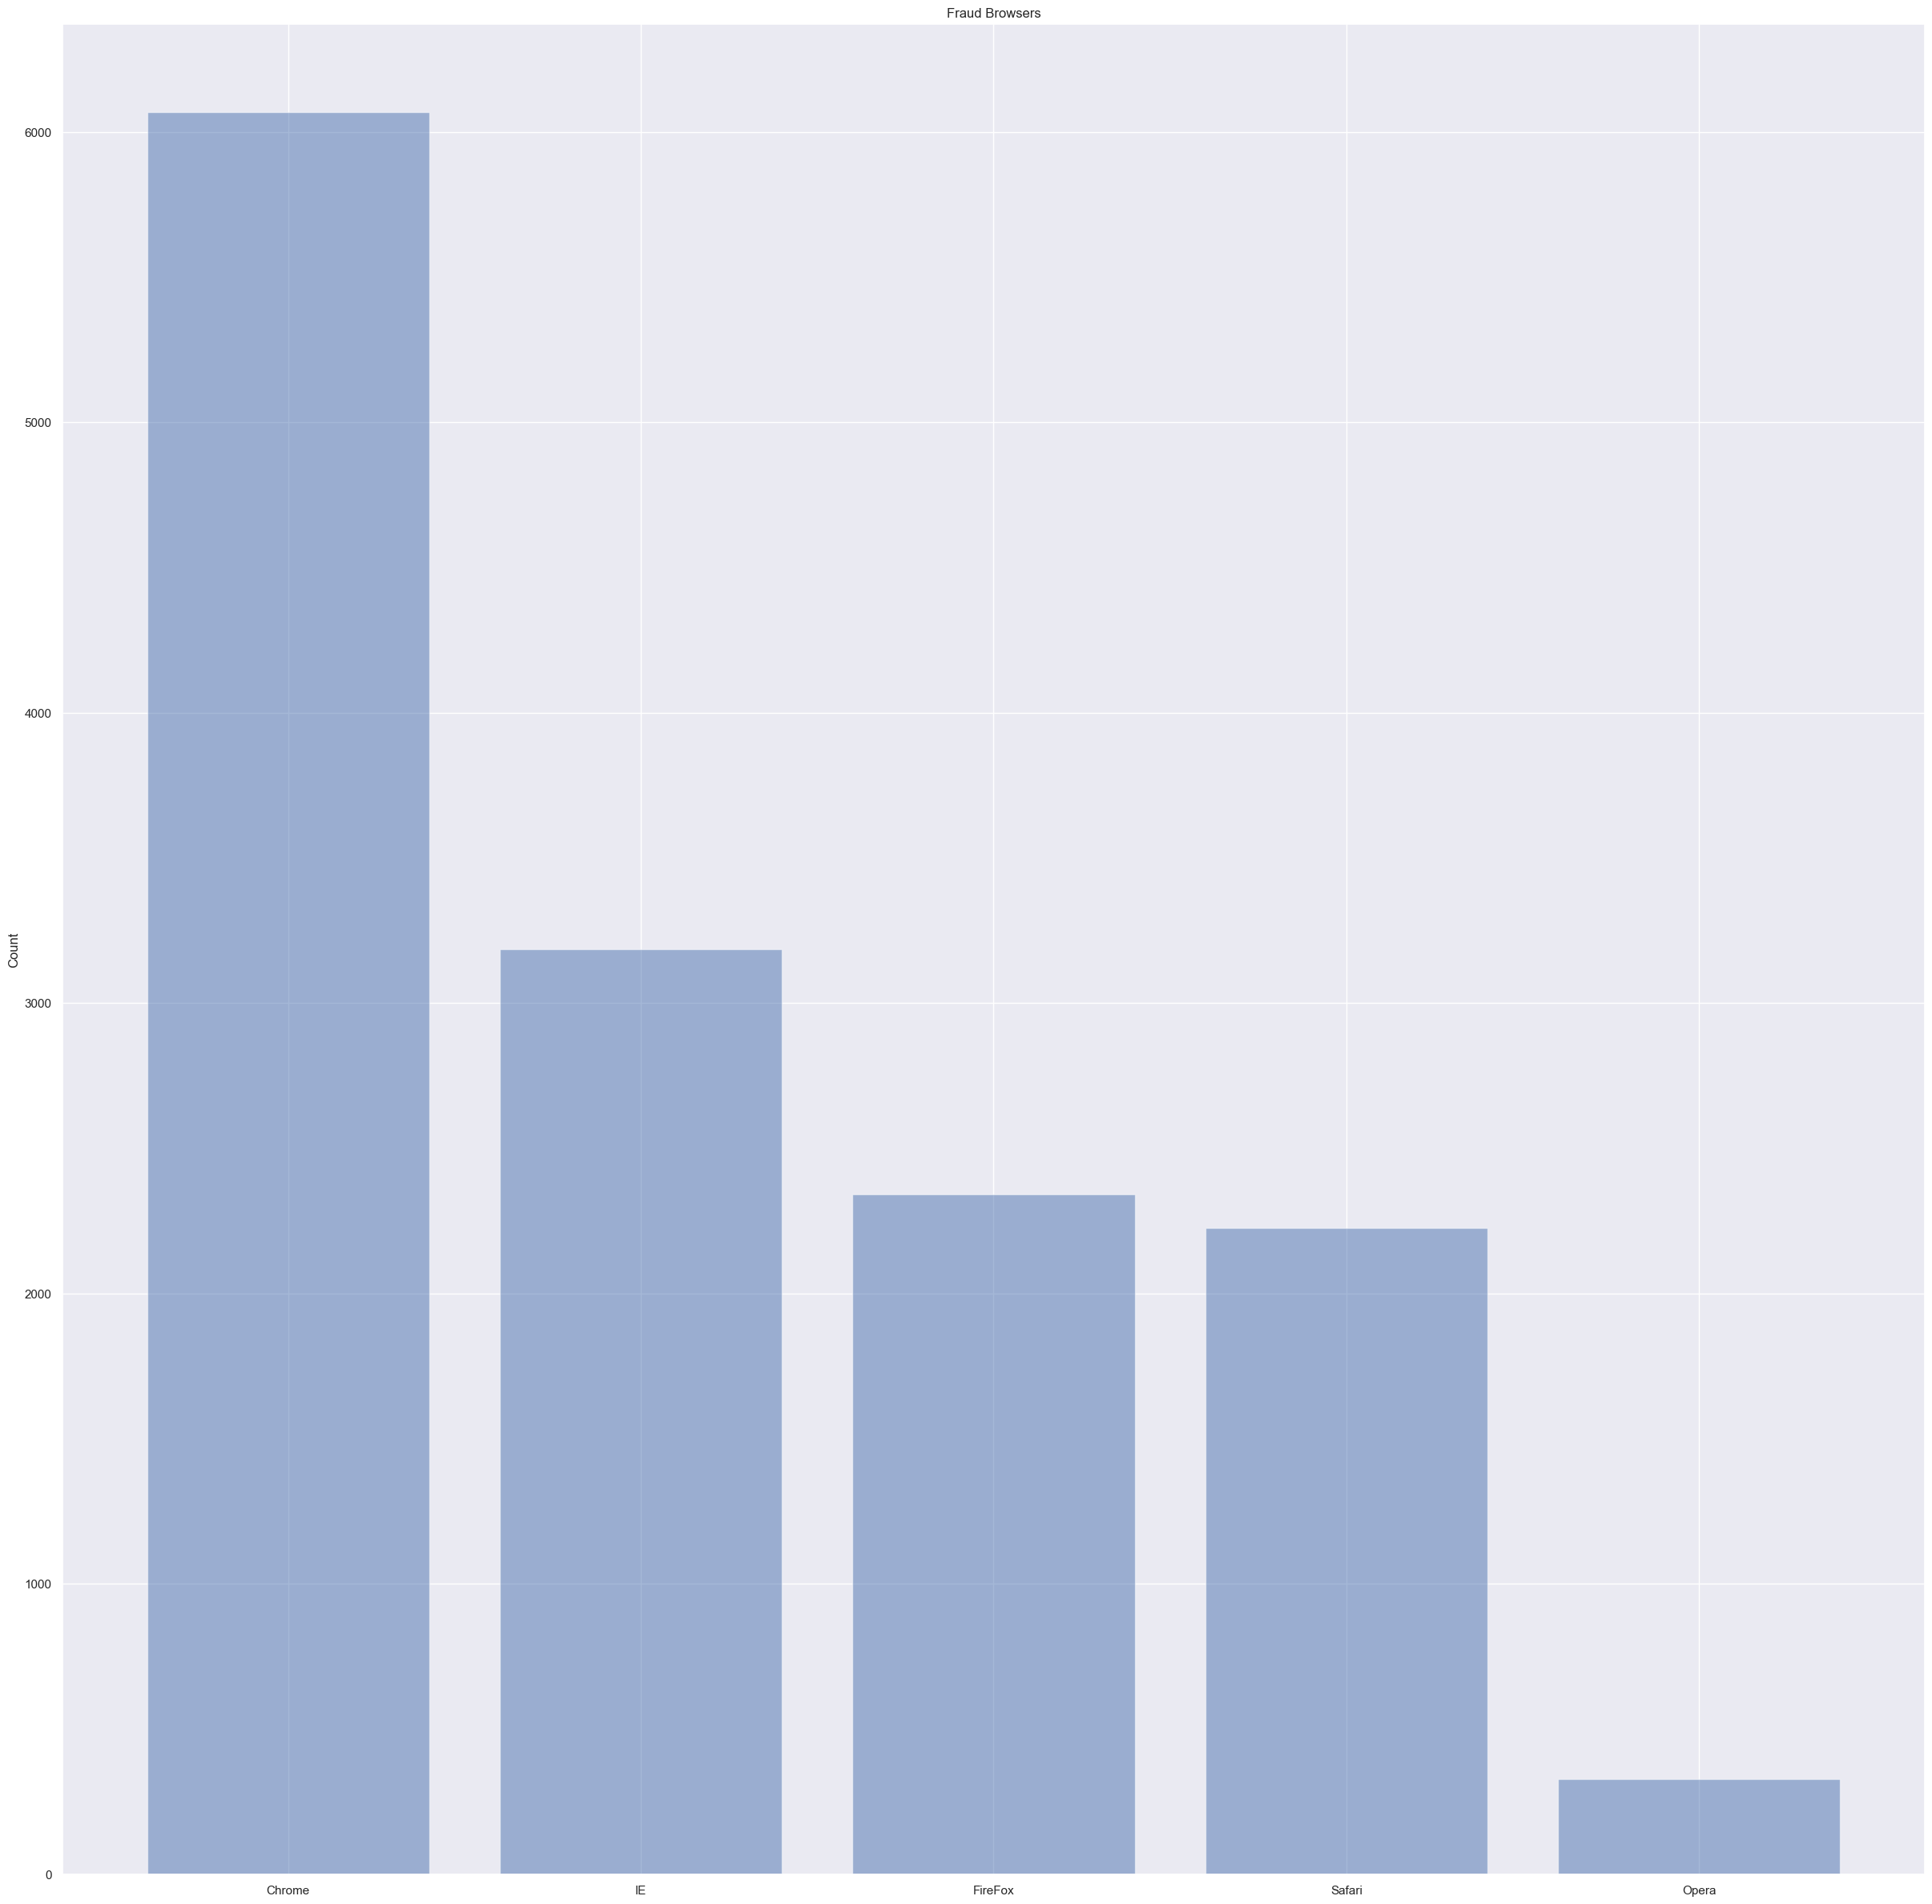

In [159]:
browsers = pd.DataFrame(f_data.browser.value_counts()).reset_index()
browsers.columns = ["Browser","Count"]
plt.bar(browsers.Browser, browsers.Count, align='center', alpha=0.5)
plt.ylabel('Count')
plt.title('Fraud Browsers')

plt.show()

Benford's law for purchase_value

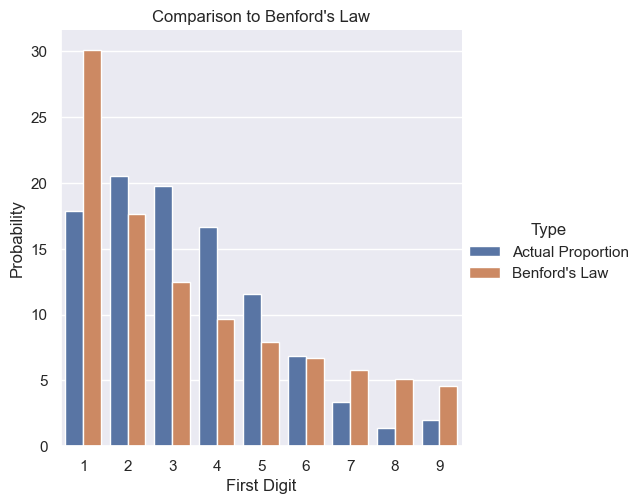

In [160]:
df_benford = dataset.copy()

df_benford['purchase_value'] = df_benford["purchase_value"].astype(str)
df_benford['first_digit'] = df_benford['purchase_value'].str.slice(0,1)

# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])
temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)
temp = temp.drop(columns = ["level_0"])
temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")

plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

Benford's law for userid

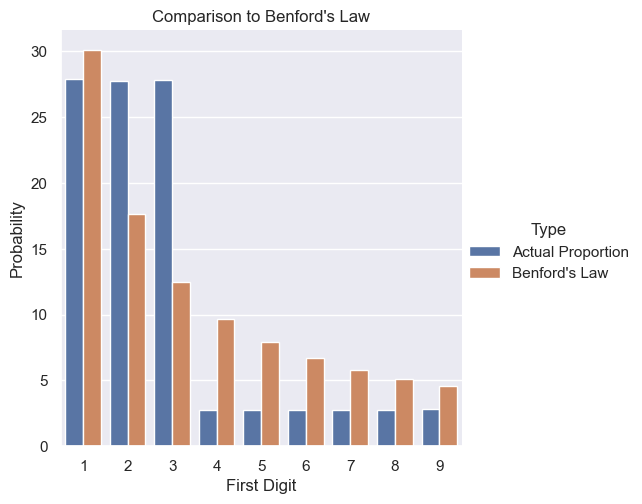

In [161]:
df_benford = dataset.copy()

df_benford['user_id'] = df_benford["user_id"].astype(str)
df_benford['first_digit'] = df_benford['user_id'].str.slice(0,1)

# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])
temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)
temp = temp.drop(columns = ["level_0"])
temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")

plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

Boxplot

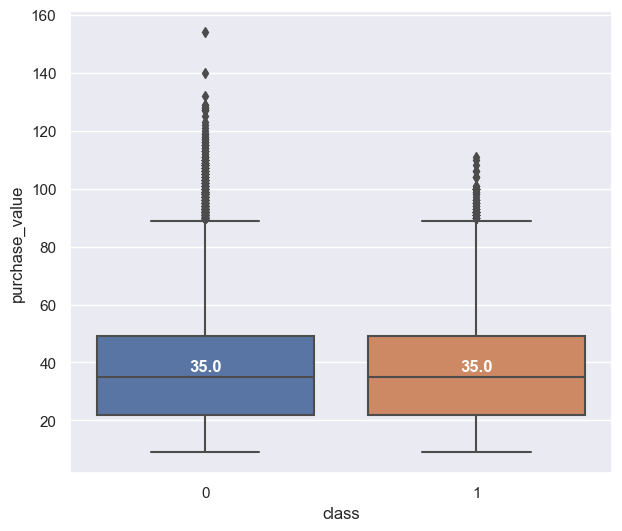

In [162]:
sns.set(rc={'figure.figsize':(7,6)})
box_plot = sns.boxplot(data=dataset , y='purchase_value', x='class')
medians = dataset.groupby(['class'])['purchase_value'].median()
vertical_offset = dataset['purchase_value'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')

Making new features 

In [163]:
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

In [164]:
# IP_table.upper_bound_ip_address.astype("float")
# IP_table.lower_bound_ip_address.astype("float")
# dataset.ip_address.astype("float")

# # function that takes an IP address as argument and returns country associated based on IP_table

# def IP_to_country(ip) :
#     try :
#         return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
#                                 & 
#                                 (IP_table.upper_bound_ip_address > ip)].iloc[0]
#     except IndexError :
#         return "Unknown"     
# dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

In [165]:
# dataset = dataset.merge(device_duplicates, on= "device_id")

# # --- 1 ---
# # Categorisation column freq_device
# # We see a clear correlation between freq_device and fraudulent activities. We are going to split freq_device in 7 categories
# dataset.freq_device = dataset.freq_device.apply(lambda x :
#                                                 str(x) if x <5 else
#                                                 "5-10" if x>=5 and x<=10 else
#                                                 "11-15" if x>10 and x<=15 else
#                                                 "> 15")

# # We convert signup_time and purchase_time en datetime

# dataset.signup_time = pd.to_datetime(dataset.signup_time, format = '%Y-%m-%d %H:%M:%S')
# dataset.purchase_time = pd.to_datetime(dataset.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# # We add features 

# # --- 2 ---
# # Column month
# dataset["month_purchase"] = dataset.purchase_time.apply(lambda x: calendar.month_name[x.month])

# # --- 3 ---
# # Column week
# dataset["weekday_purchase"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# # --- 4 ---
# # Column hour_of_the_day
# dataset["hour_of_the_day"] = dataset.purchase_time.apply(lambda x: x.hour)

# # --- 5 ---
# # Column seconds_since_signup
# dataset["seconds_since_signup"]= (dataset.purchase_time - dataset.signup_time).apply(lambda x : x.total_seconds())

# # --- 6 ---
# # Column countries_from_device (ie. number of different countries per device_id)

# # We flag devices that committed purchases from different countries
# # First we groupby device_id and IP_country which will give us a DF with a sublist of country for each device_id
# country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# # Then we can count the number of different countries by device_id
# country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# # Finally we can merge this to our main dataset
# dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
# dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

# # --- 7 ---
# # Column risk_country which classifies each country based on historical fraud rate from these countries

# # We calculate the proportion of fraud by country
# risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))

# # We classify each country between Very High risk, High risk, Medium risk and low risk
# risk_country["risk_country"] = risk_country["class"].apply(lambda x : 
#                                                            "Very High risk" if x > 0.25 else
#                                                            "High risk" if x > 0.05 else
#                                                            "Medium risk" if x > 0.01 else
#                                                            "Low risk")
                                                
# # We merge with dataset
# dataset = dataset.merge(risk_country.drop("class", axis = 1), left_on= "IP_country", right_index = True)

# # --- 8 ---
# # Column "quick_purchase" : categorise time between sign_up and purchase
# dataset["quick_purchase"] = dataset.seconds_since_signup.apply(lambda x : 1 if x < 30 else 0)

# # --- 9 ---
# # Column freq_same_purchase : indicates how many times a given device_id purchased an item of the same value

# # We generate a table indicating for each line if the couple device_id / purchase_value has duplicates
# duplicate = dataset.duplicated(subset = ["purchase_value","device_id"], keep = False)
# # We merge it with a DF containing purchase_value and device_id
# duplicate = pd.concat([dataset.loc[:,["purchase_value","device_id"]], duplicate],axis=1)
# # We build a DataFrame which gives us the number of duplicates for each combination of device_id / purchase_value
# duplicate = duplicate.groupby(by = ["device_id","purchase_value"]).sum()
# # We categorise number of time the same purchase has been made 
# duplicate["freq_same_purchase"] = duplicate[0].apply(lambda x : 
#                                                 x if x < 5 else
#                                                 "5-10" if x<=10 else
#                                                 "11-15" if x<= 15 else
#                                                 ">15" 
#                                                )
                                            
# # We merge the result with main dataset            
# dataset = dataset.merge(duplicate.drop(0,axis=1), left_on=["device_id","purchase_value"], right_index = True)

# # --- 10 ---- 
# # age categorisation

# dataset["age_category"] = dataset.age.apply(lambda x : 
#                  "< 40" if x < 40 else
#                  "40 - 49" if x < 50 else
#                  "50 -59" if x < 60 else
#                  "60 - 69" if x < 70 else
#                  " > 70")

# # ---- 11 ----
# # Hour of the day categorisation
# dataset["period_of_the_day"] = dataset.hour_of_the_day.apply(lambda x : 
#                                                              "late night" if x < 4 else
#                                                              "early morning" if x < 8 else
#                                                              "morning" if x < 12 else
#                                                              "early afternoon" if x < 16 else
#                                                              "afternoon" if x < 20 else
#                                                              "evening"
#                                                             )

In [166]:
import calendar
dataset['signup_time'] =  pd.to_datetime(dataset['signup_time'], format='%Y-%m-%d %H:%M:%S')
dataset['purchase_time'] =  pd.to_datetime(dataset['purchase_time'], format='%Y-%m-%d %H:%M:%S')
# get diff in days, time, seconds, fast_purchase from purchase_time and signup_time
dataset['diff_dt'] = dataset['signup_time'] - dataset['purchase_time']
dataset['days'] = dataset['diff_dt'].dt.days
dataset['time'] = dataset['diff_dt'].astype(str).apply(lambda x : x[-8:])
#dataset["time"] = pd.to_datetime(dataset['time'],format= '%H:%M:%S' ).dt.time
dataset['seconds_after_signup'] = dataset['diff_dt'].dt.seconds
dataset['fast_purchase'] = dataset['seconds_after_signup'].apply(lambda x: '1' if x < 30 else '0')

# get month, week, hour of the day from purchase_time
dataset['month_purchase'] = pd.to_datetime(dataset['purchase_time']).dt.strftime('%B')
dataset['weekday_purchase'] = pd.to_datetime(dataset['purchase_time']).dt.strftime('%A')
dataset['hour_of_the_day'] = pd.to_datetime(dataset['purchase_time']).dt.strftime('%H').astype(int)

# categorise hour of the day
dataset["time_of_day"] = dataset['hour_of_the_day'].apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early afternoon" if x < 16 else
                                                             "afternoon" if x < 20 else
                                                             "evening"
                                                            )

# get country risk from mean of class
risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))
risk_country["risk_country"] = risk_country["class"].apply(lambda x:"High Risk" if x > 0.25 else "Medium Risk" if x > 0.10 else "Low Risk")
dataset = dataset.merge(risk_country.drop("class",axis=1),left_on='IP_country', right_on = 'IP_country')

# get count of duplicated devices
device_duplicates = dataset.groupby('device_id')['device_id'].count().rename('freq_device').reset_index()
dataset = dataset.merge(device_duplicates, on='device_id')
dataset['freq_device'] = dataset['freq_device'].apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# get count of countries by device_id
country_count = dataset.groupby(["device_id", "IP_country"])['IP_country'].count().rename('country_count').reset_index()
dataset = dataset.merge(country_count, on=["device_id", 'IP_country'], how='left')

# get count of same purchase by device_id
duplicate = dataset.groupby(['device_id', 'purchase_value'])['purchase_value'].count().rename('freq_same_purchase').reset_index()
dataset = dataset.merge(duplicate, on=['device_id', 'purchase_value'], how='left')
dataset["freq_same_purchase"] = dataset['freq_same_purchase'].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )

# categorise age
dataset["age_category"] = dataset['age'].apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

dataset = dataset.drop(columns=['diff_dt', 'days', 'time'])

In [167]:
country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

In [168]:
dataset.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'IP_country', 'seconds_after_signup', 'fast_purchase', 'month_purchase',
       'weekday_purchase', 'hour_of_the_day', 'time_of_day', 'risk_country',
       'freq_device', 'country_count', 'freq_same_purchase', 'age_category',
       'countries_from_device'],
      dtype='object')

## Data Visualisation for the new columns

In [169]:
f_data = dataset[dataset["class"] == 1]
non_f_data = dataset[dataset["class"] == 0]

C:\Users\J\AppData\Local\Temp\ipykernel_2528\2362680609.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['month_purchase'] = pd.Categorical(f_data['month_purchase'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
C:\Users\J\AppData\Local\Temp\ipykernel_2528\2362680609.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  f_data['weekday_purchase'] = pd.Categorical(f_data['weekday_purchase'], categor

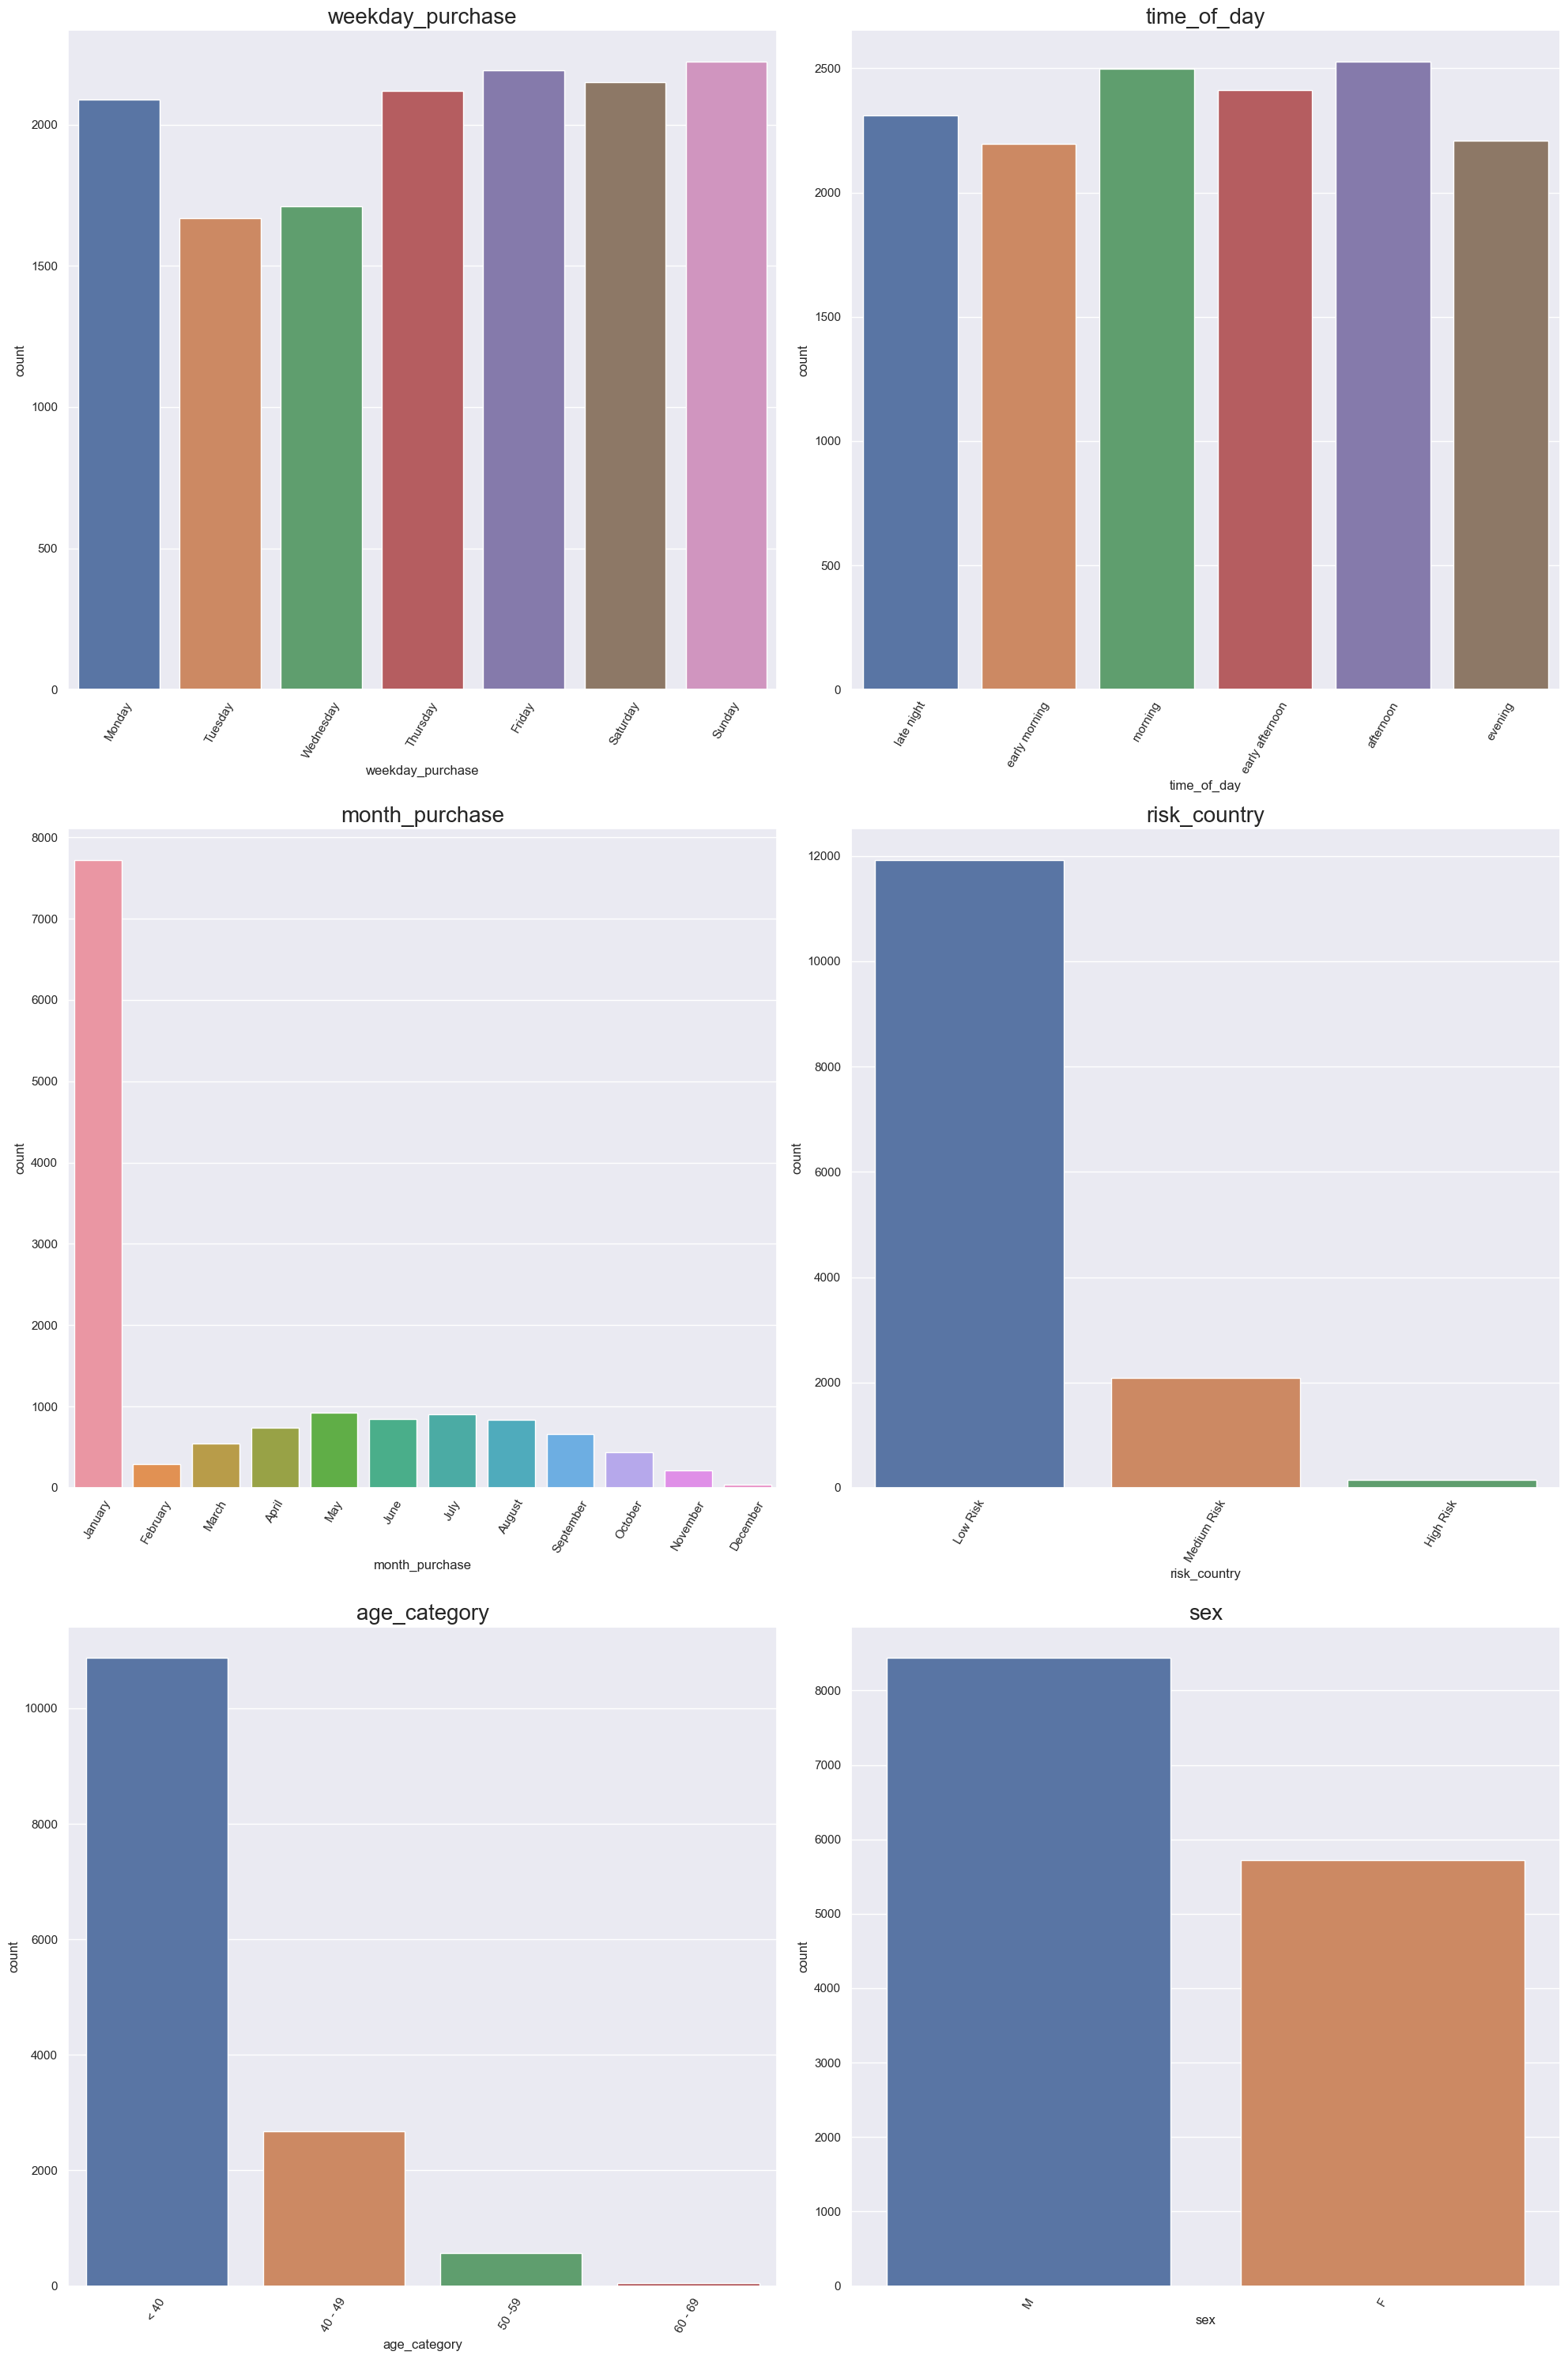

In [170]:
cat_variables = ['month_purchase', 'weekday_purchase', 'time_of_day']
f_data['month_purchase'] = pd.Categorical(f_data['month_purchase'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
f_data['weekday_purchase'] = pd.Categorical(f_data['weekday_purchase'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
f_data['time_of_day'] = pd.Categorical(f_data['time_of_day'], categories=['late night', 'early morning', 'morning', 'early afternoon', 'afternoon', 'evening'], ordered=True)

non_f_data['month_purchase'] = pd.Categorical(non_f_data['month_purchase'], categories=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'], ordered=True)
non_f_data['weekday_purchase'] = pd.Categorical(non_f_data['weekday_purchase'], categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)
non_f_data['time_of_day'] = pd.Categorical(non_f_data['time_of_day'], categories=['late night', 'early morning', 'morning', 'early afternoon', 'afternoon', 'evening'], ordered=True)

cat_variables = ['weekday_purchase','time_of_day', 'month_purchase', 'risk_country', 'age_category', 'sex']

# Set up the matplotlib figure for fraud data 
f, axes = plt.subplots(3, 2, figsize=(20, 30), sharex=False)

# sns.despine(left=True)
for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=f_data, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

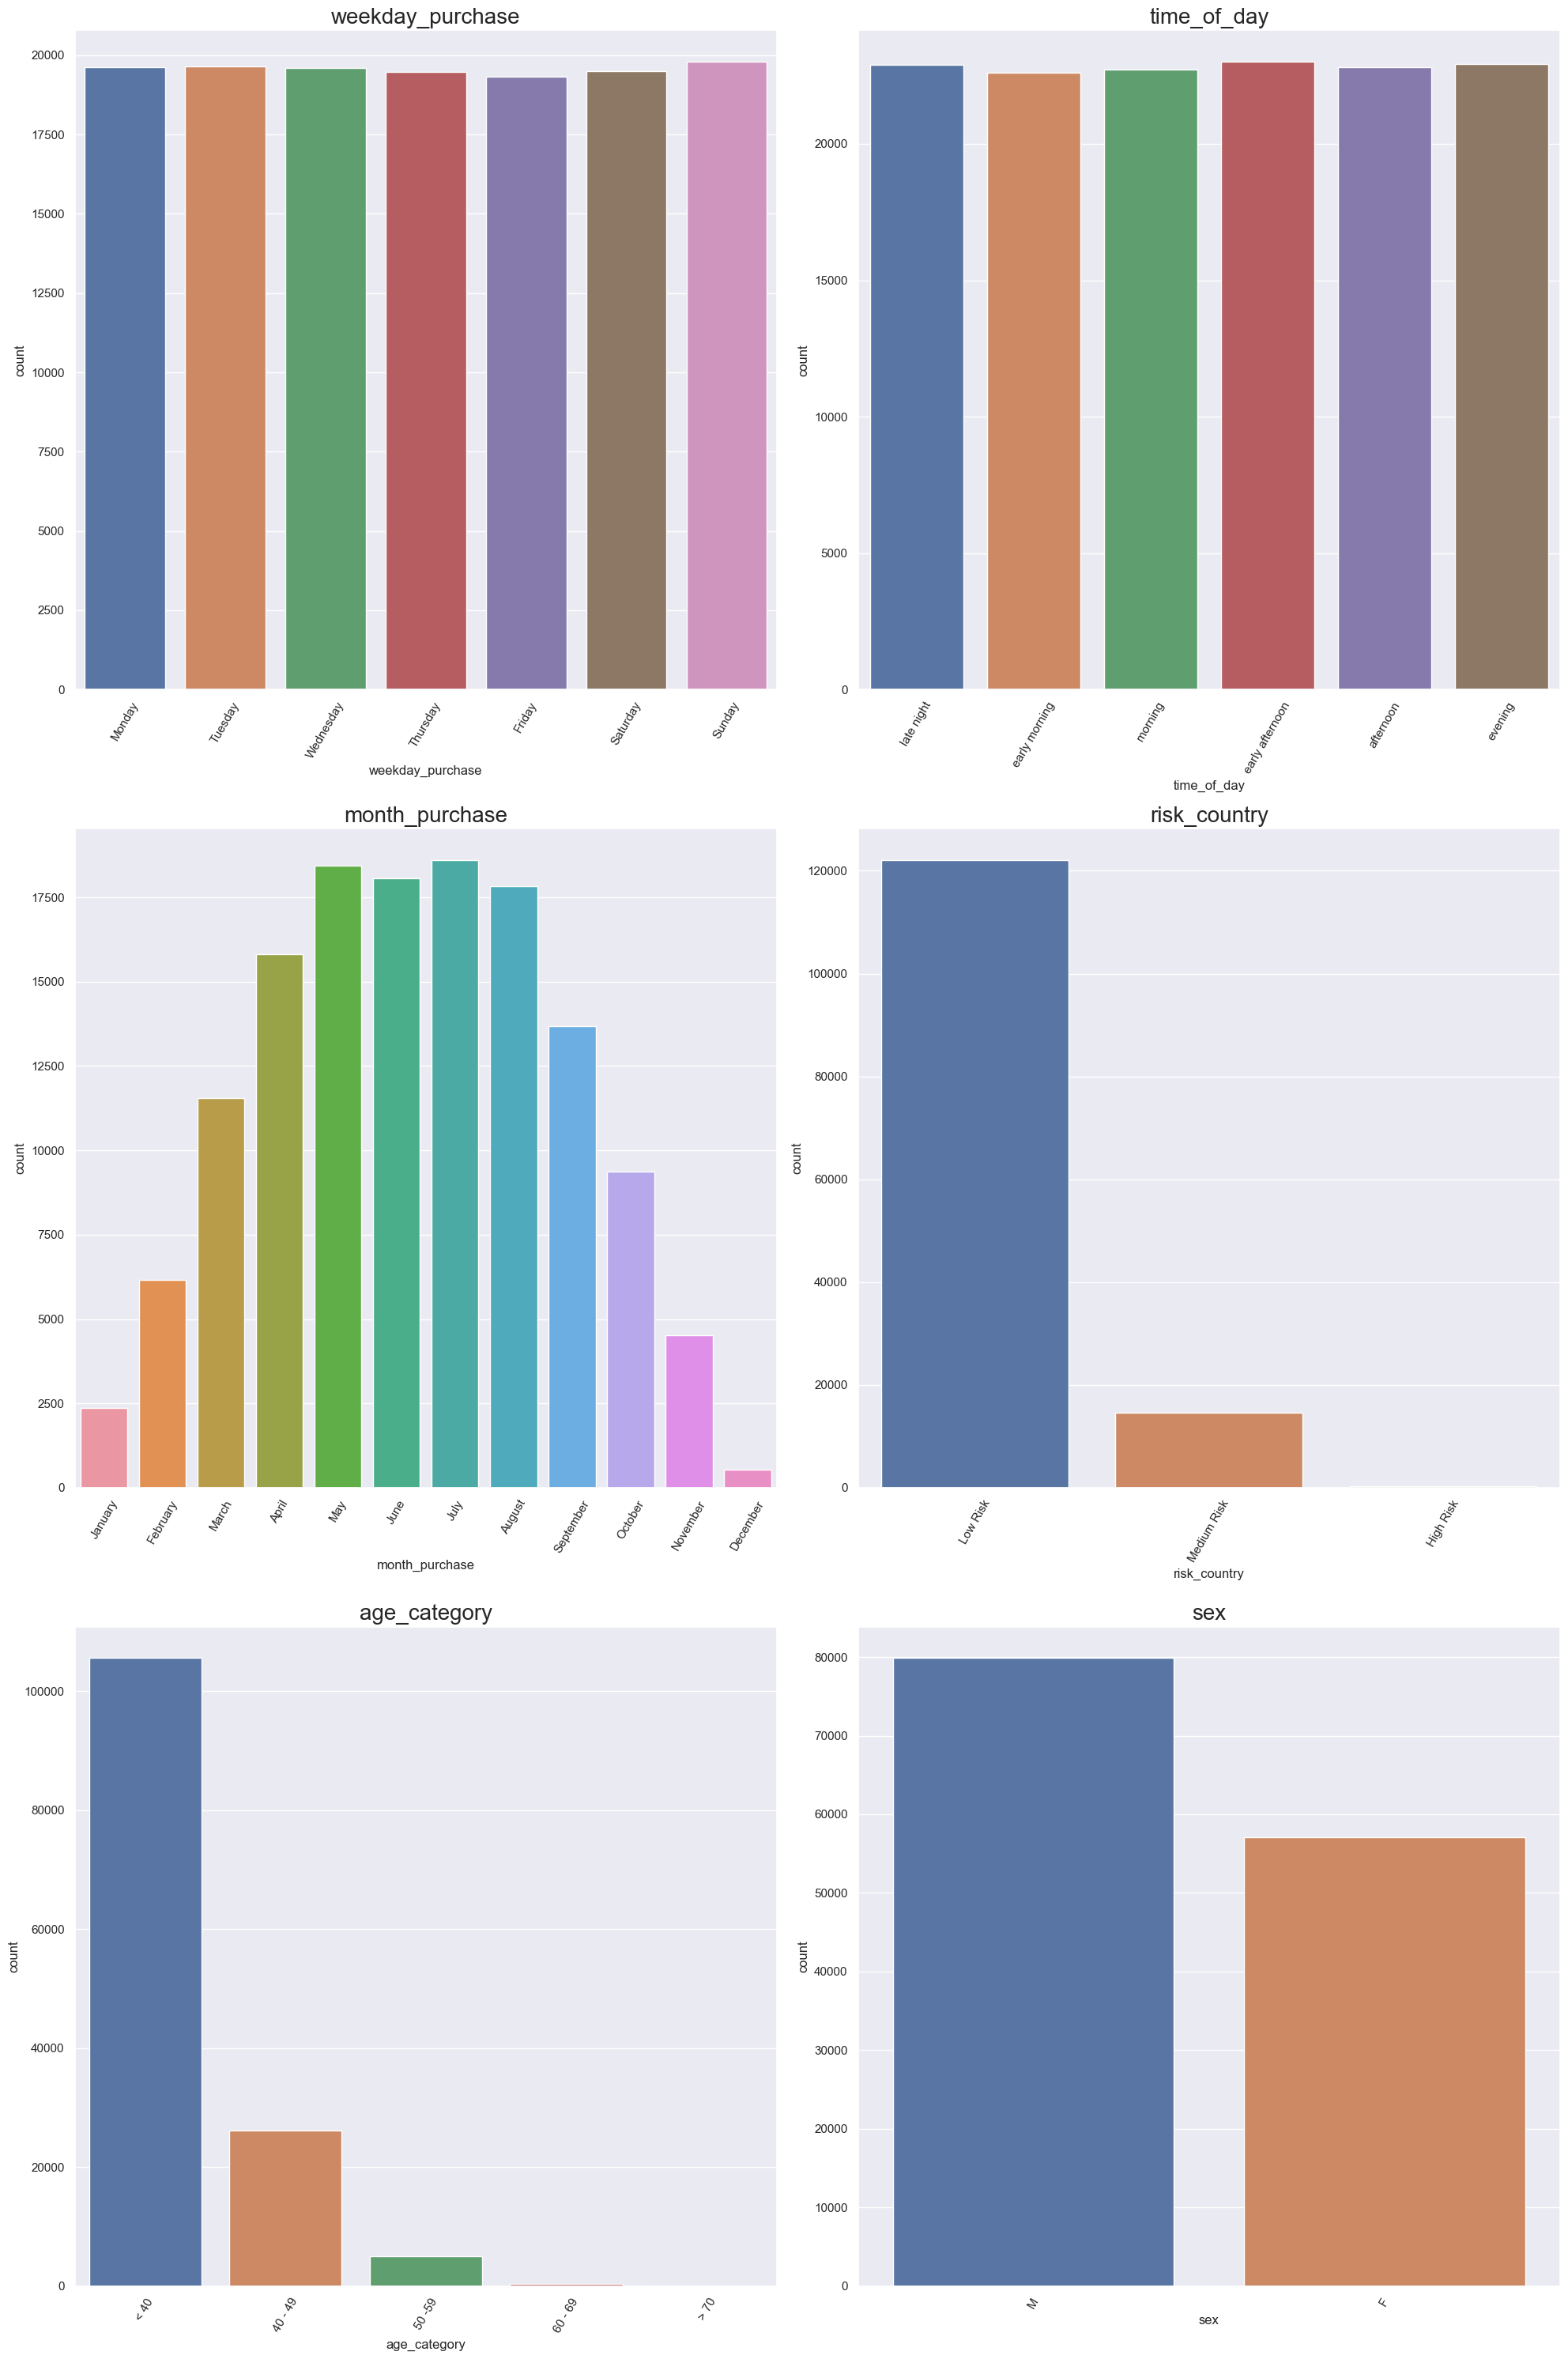

In [171]:
# Set up the matplotlib figure for non fraud data
f, axes = plt.subplots(3, 2, figsize=(20, 30), sharex=False)
# sns.despine(left=True)

for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=non_f_data, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

C:\Users\J\AppData\Local\Temp\ipykernel_2528\3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
C:\Users\J\AppData\Local\Temp\ipykernel_2528\3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
C:\Users\J\AppData\Local\Temp\ipykernel_2528\3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
C:\Users\J\AppData\Local\Temp\ipykernel_2528\3671696606.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)


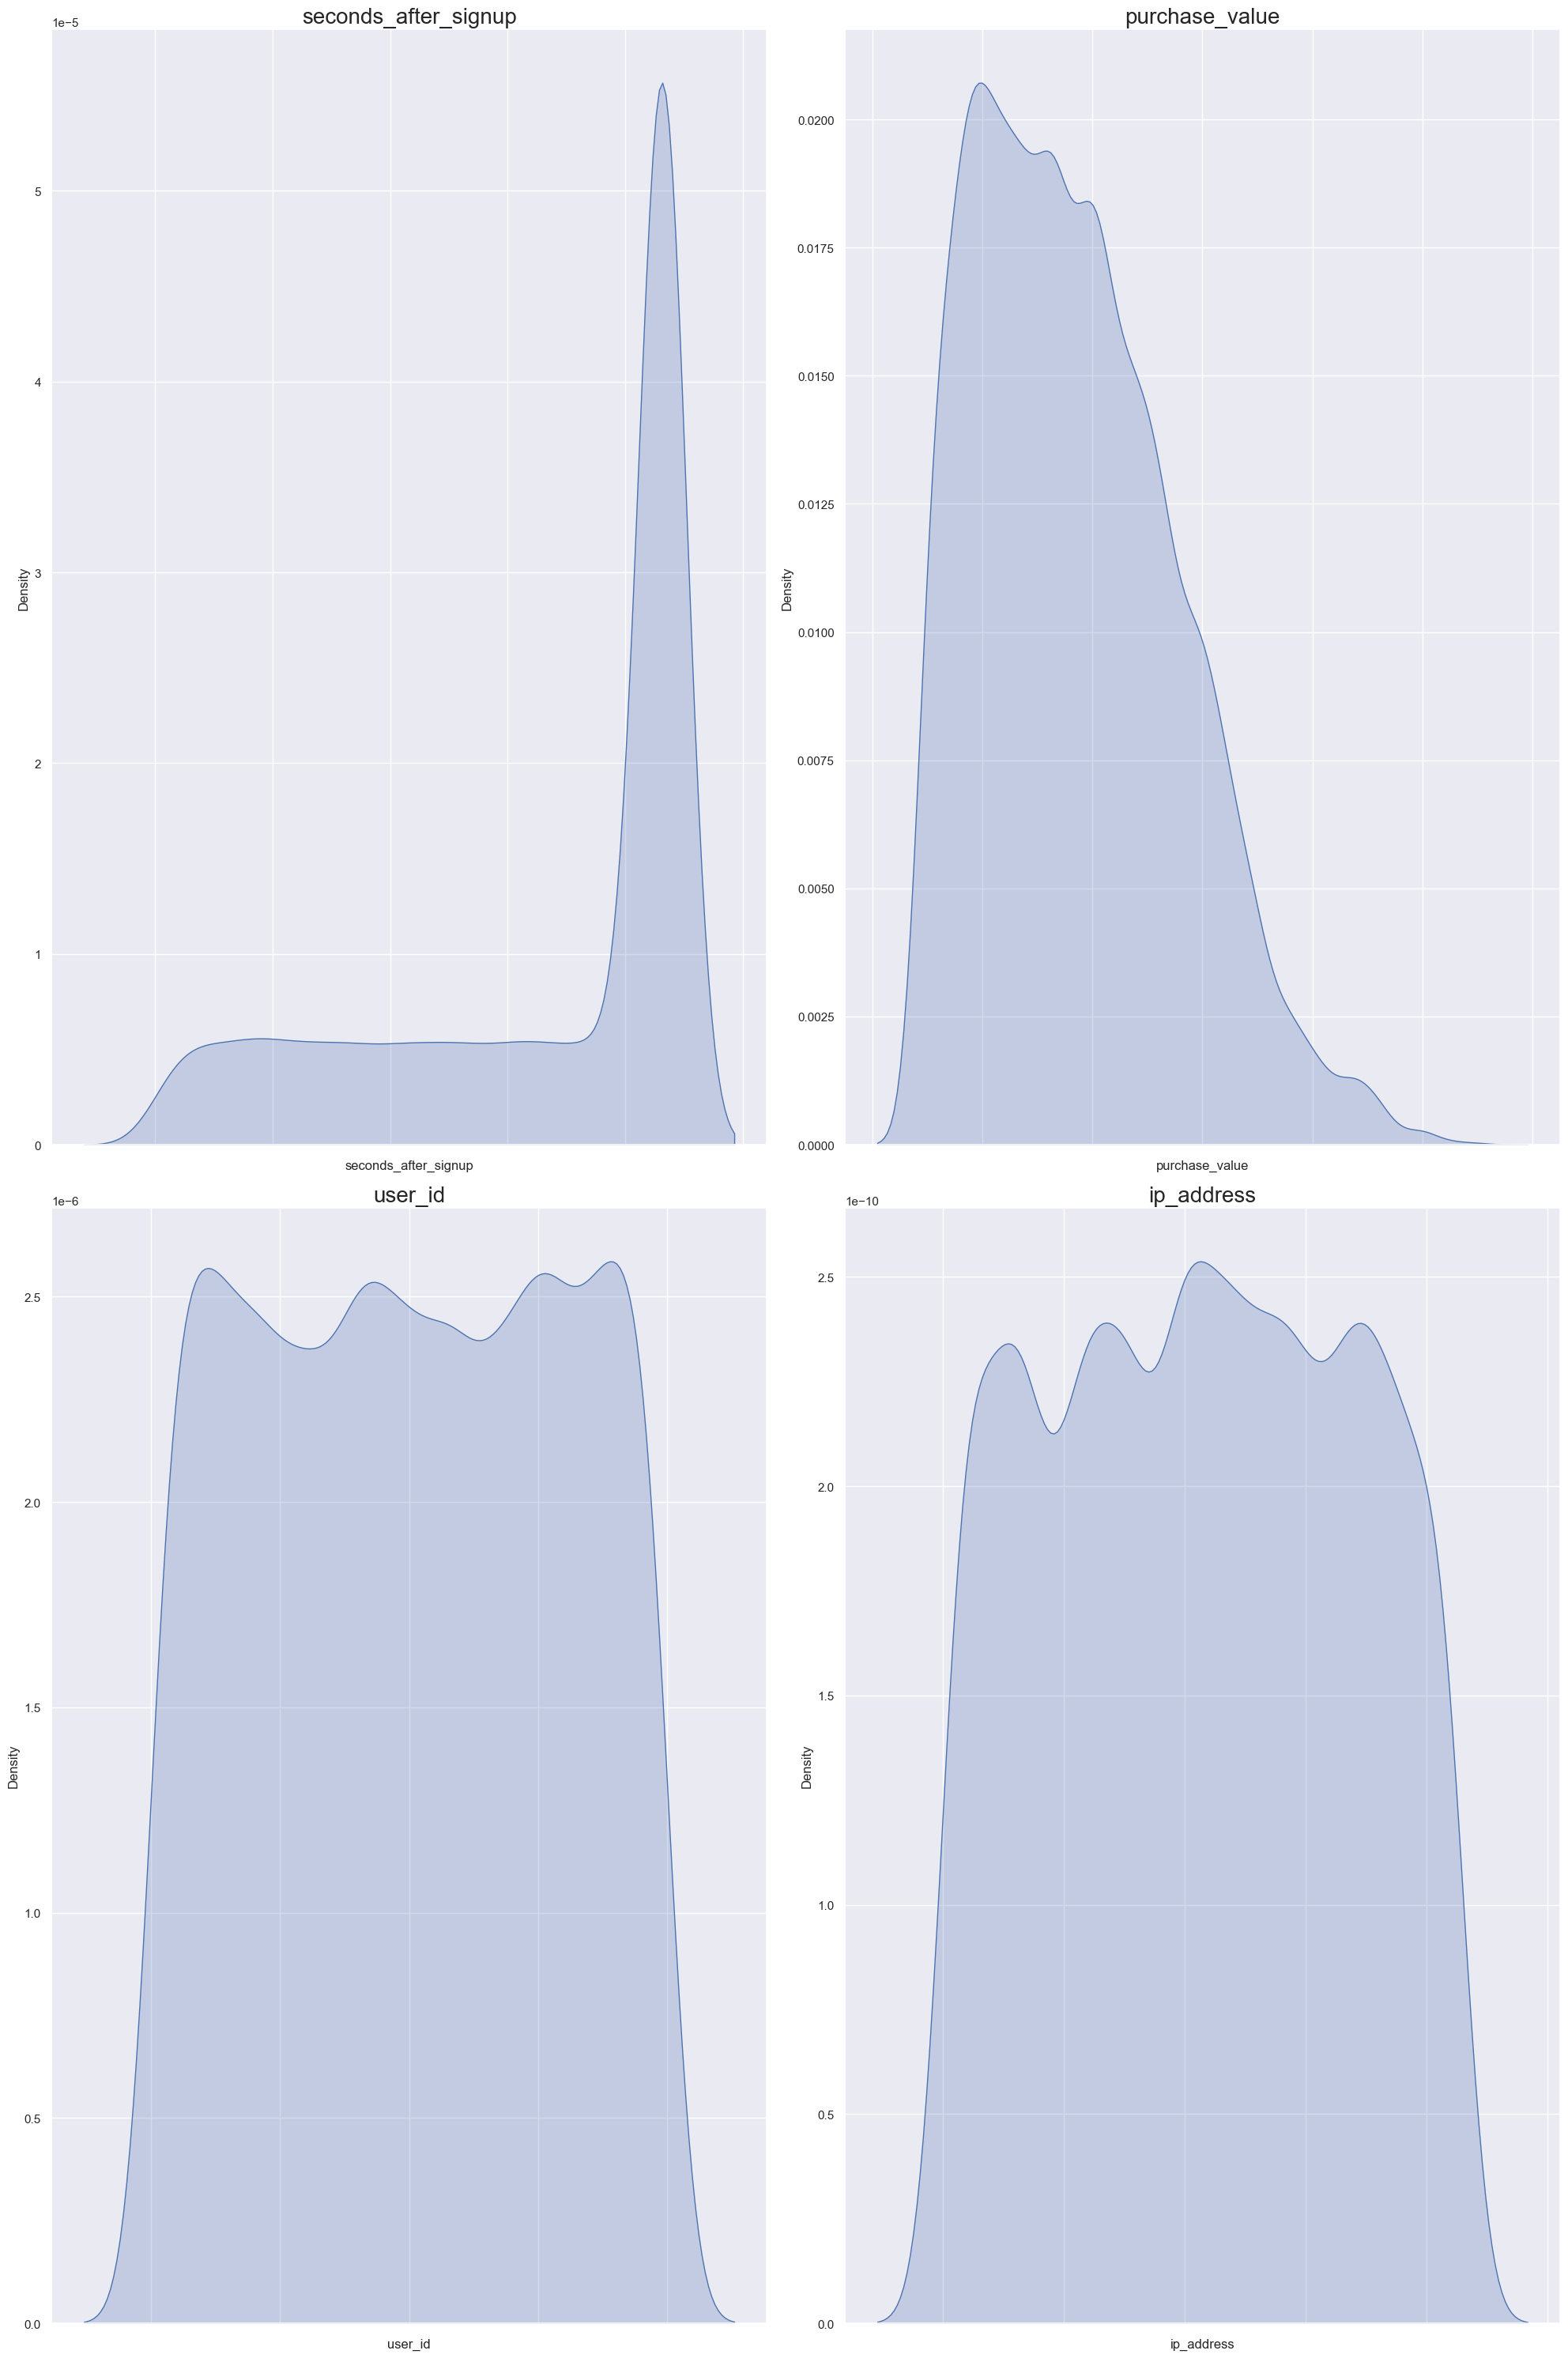

In [172]:
numerical_variables = ['seconds_after_signup', 'purchase_value', 'user_id', 'ip_address']

# Set up the matplotlib figure for fraud data
f, axes = plt.subplots(2, 2, figsize=(20, 30), sharex=False)

# sns.despine(left=True)
for index, name in enumerate(numerical_variables):
    sns.kdeplot(f_data[name], fill=True, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

C:\Users\J\AppData\Local\Temp\ipykernel_2528\2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
C:\Users\J\AppData\Local\Temp\ipykernel_2528\2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
C:\Users\J\AppData\Local\Temp\ipykernel_2528\2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
C:\Users\J\AppData\Local\Temp\ipykernel_2528\2827401691.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)


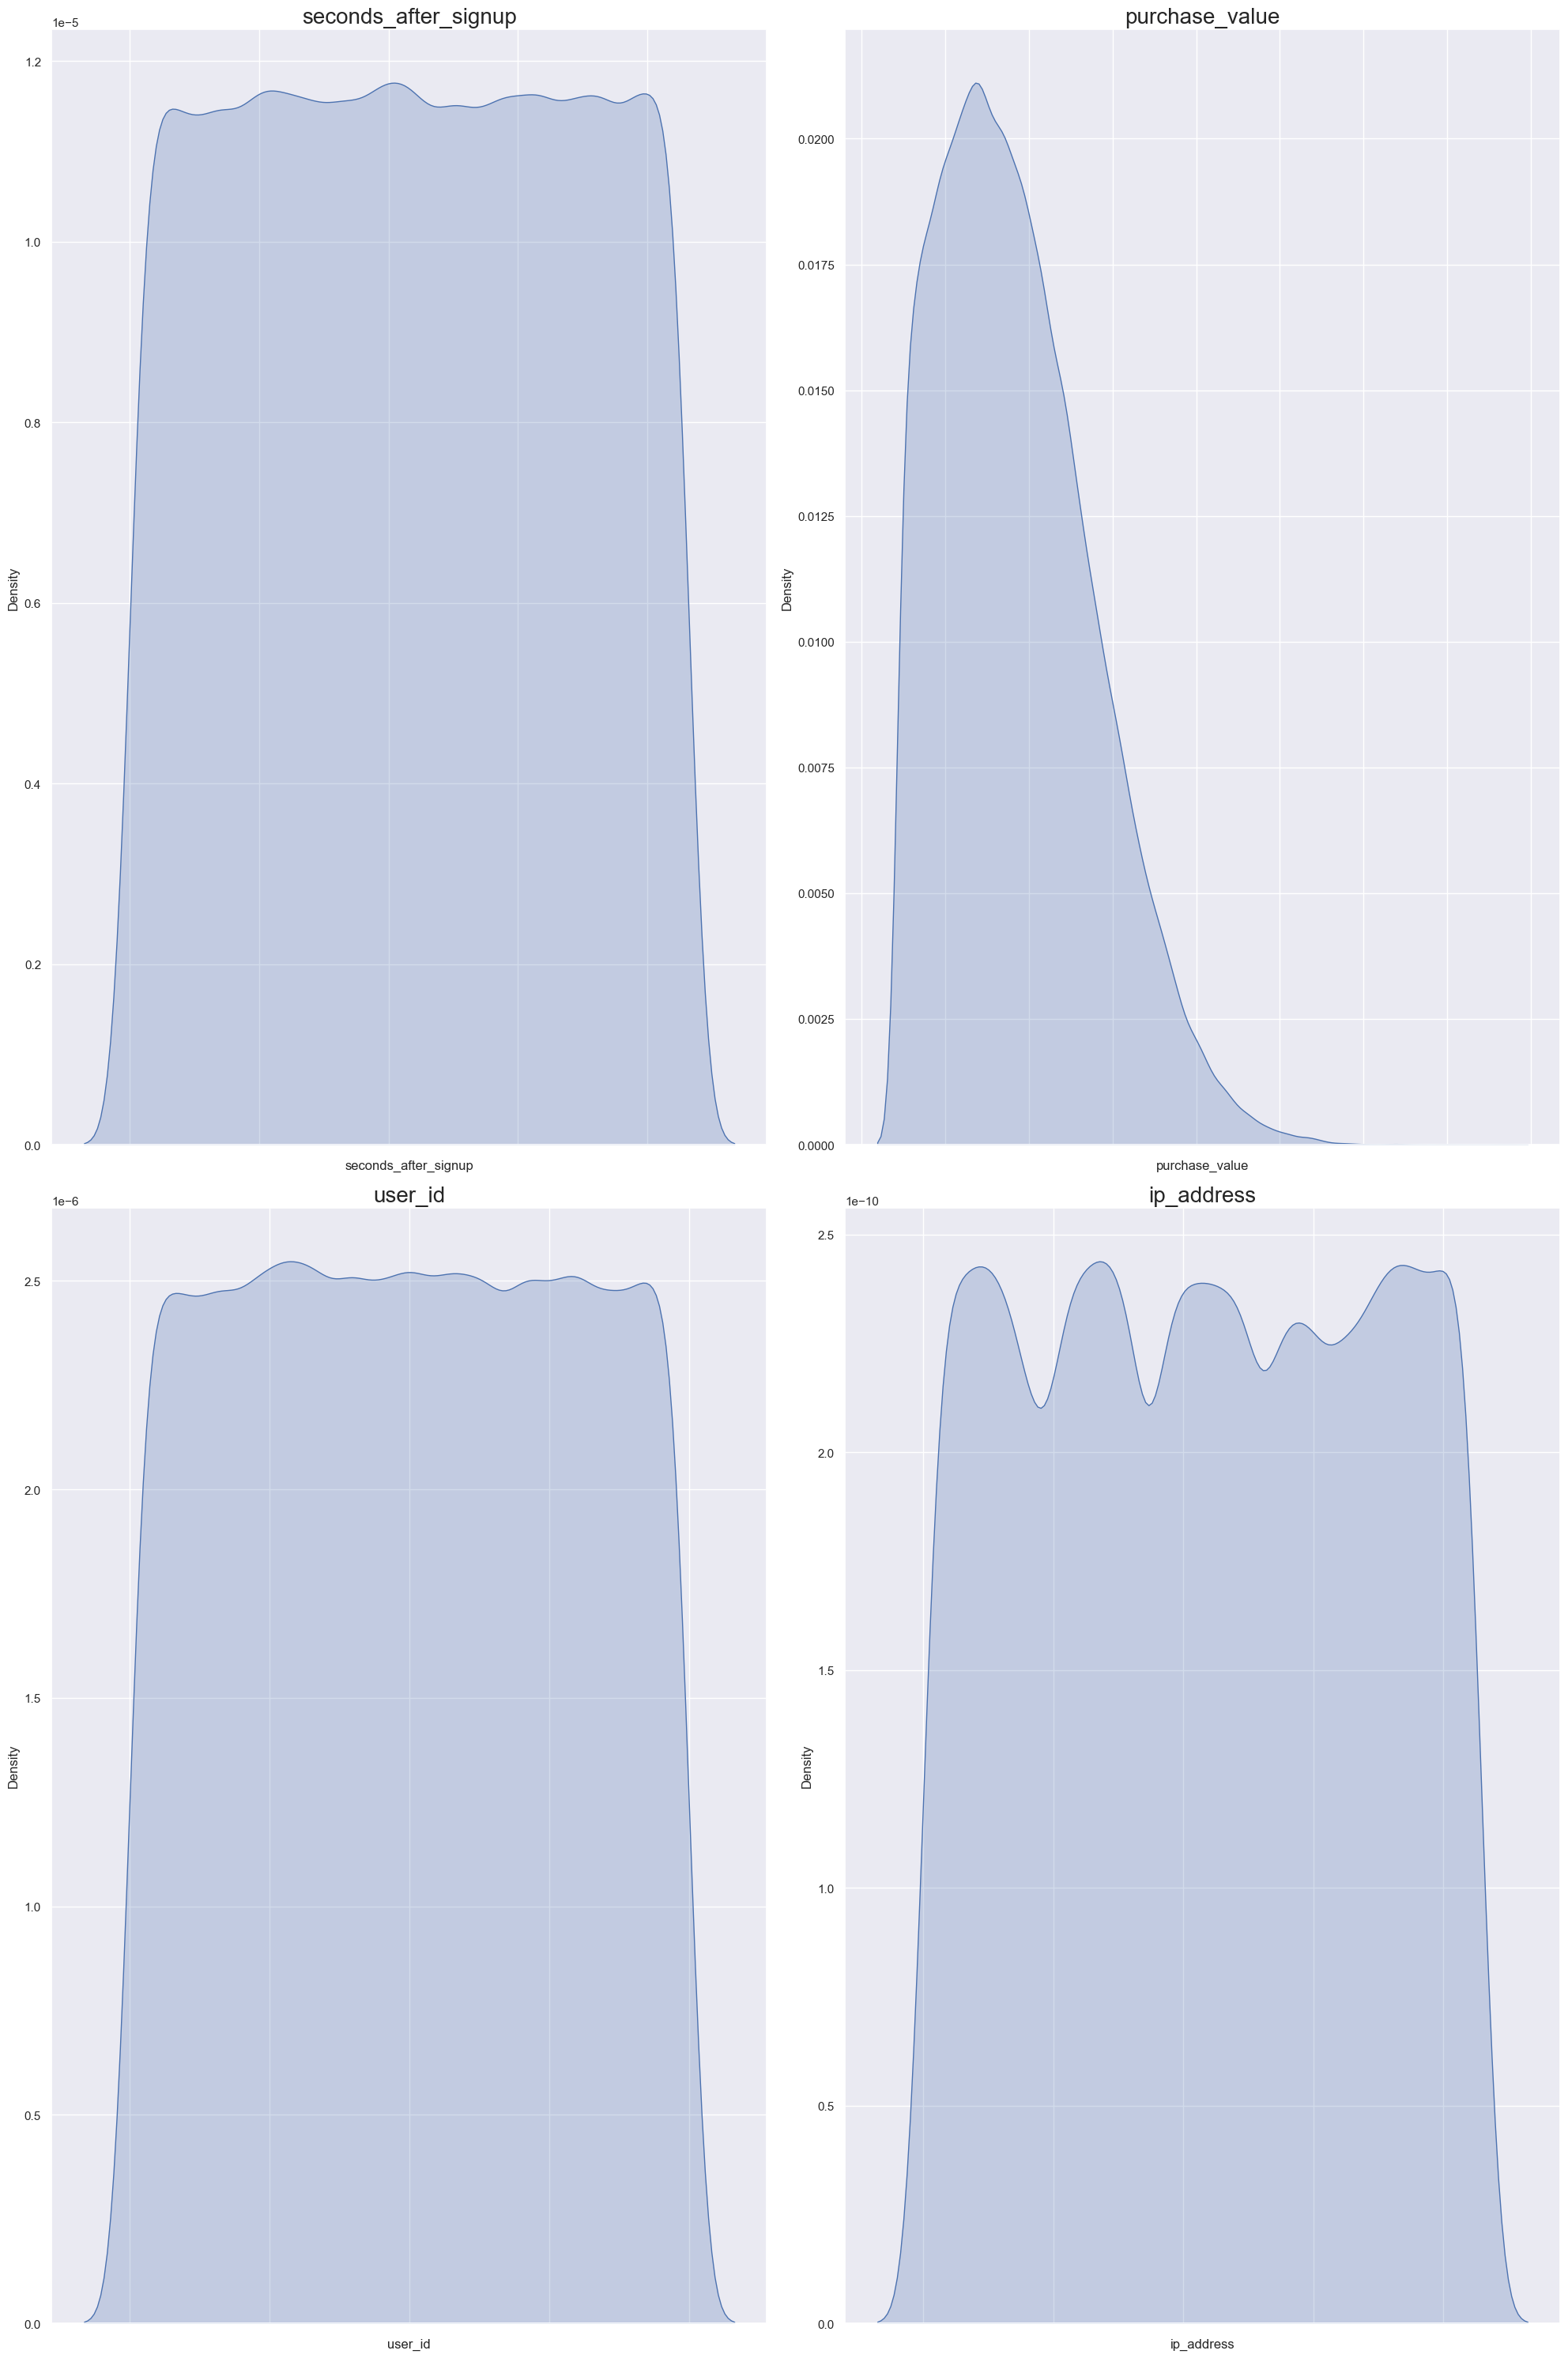

In [173]:
# Set up the matplotlib figure for non fraud data
f, axes = plt.subplots(2, 2, figsize=(20, 30), sharex=False)

# sns.despine(left=True)
for index, name in enumerate(numerical_variables):
    sns.kdeplot(non_f_data[name], fill=True, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

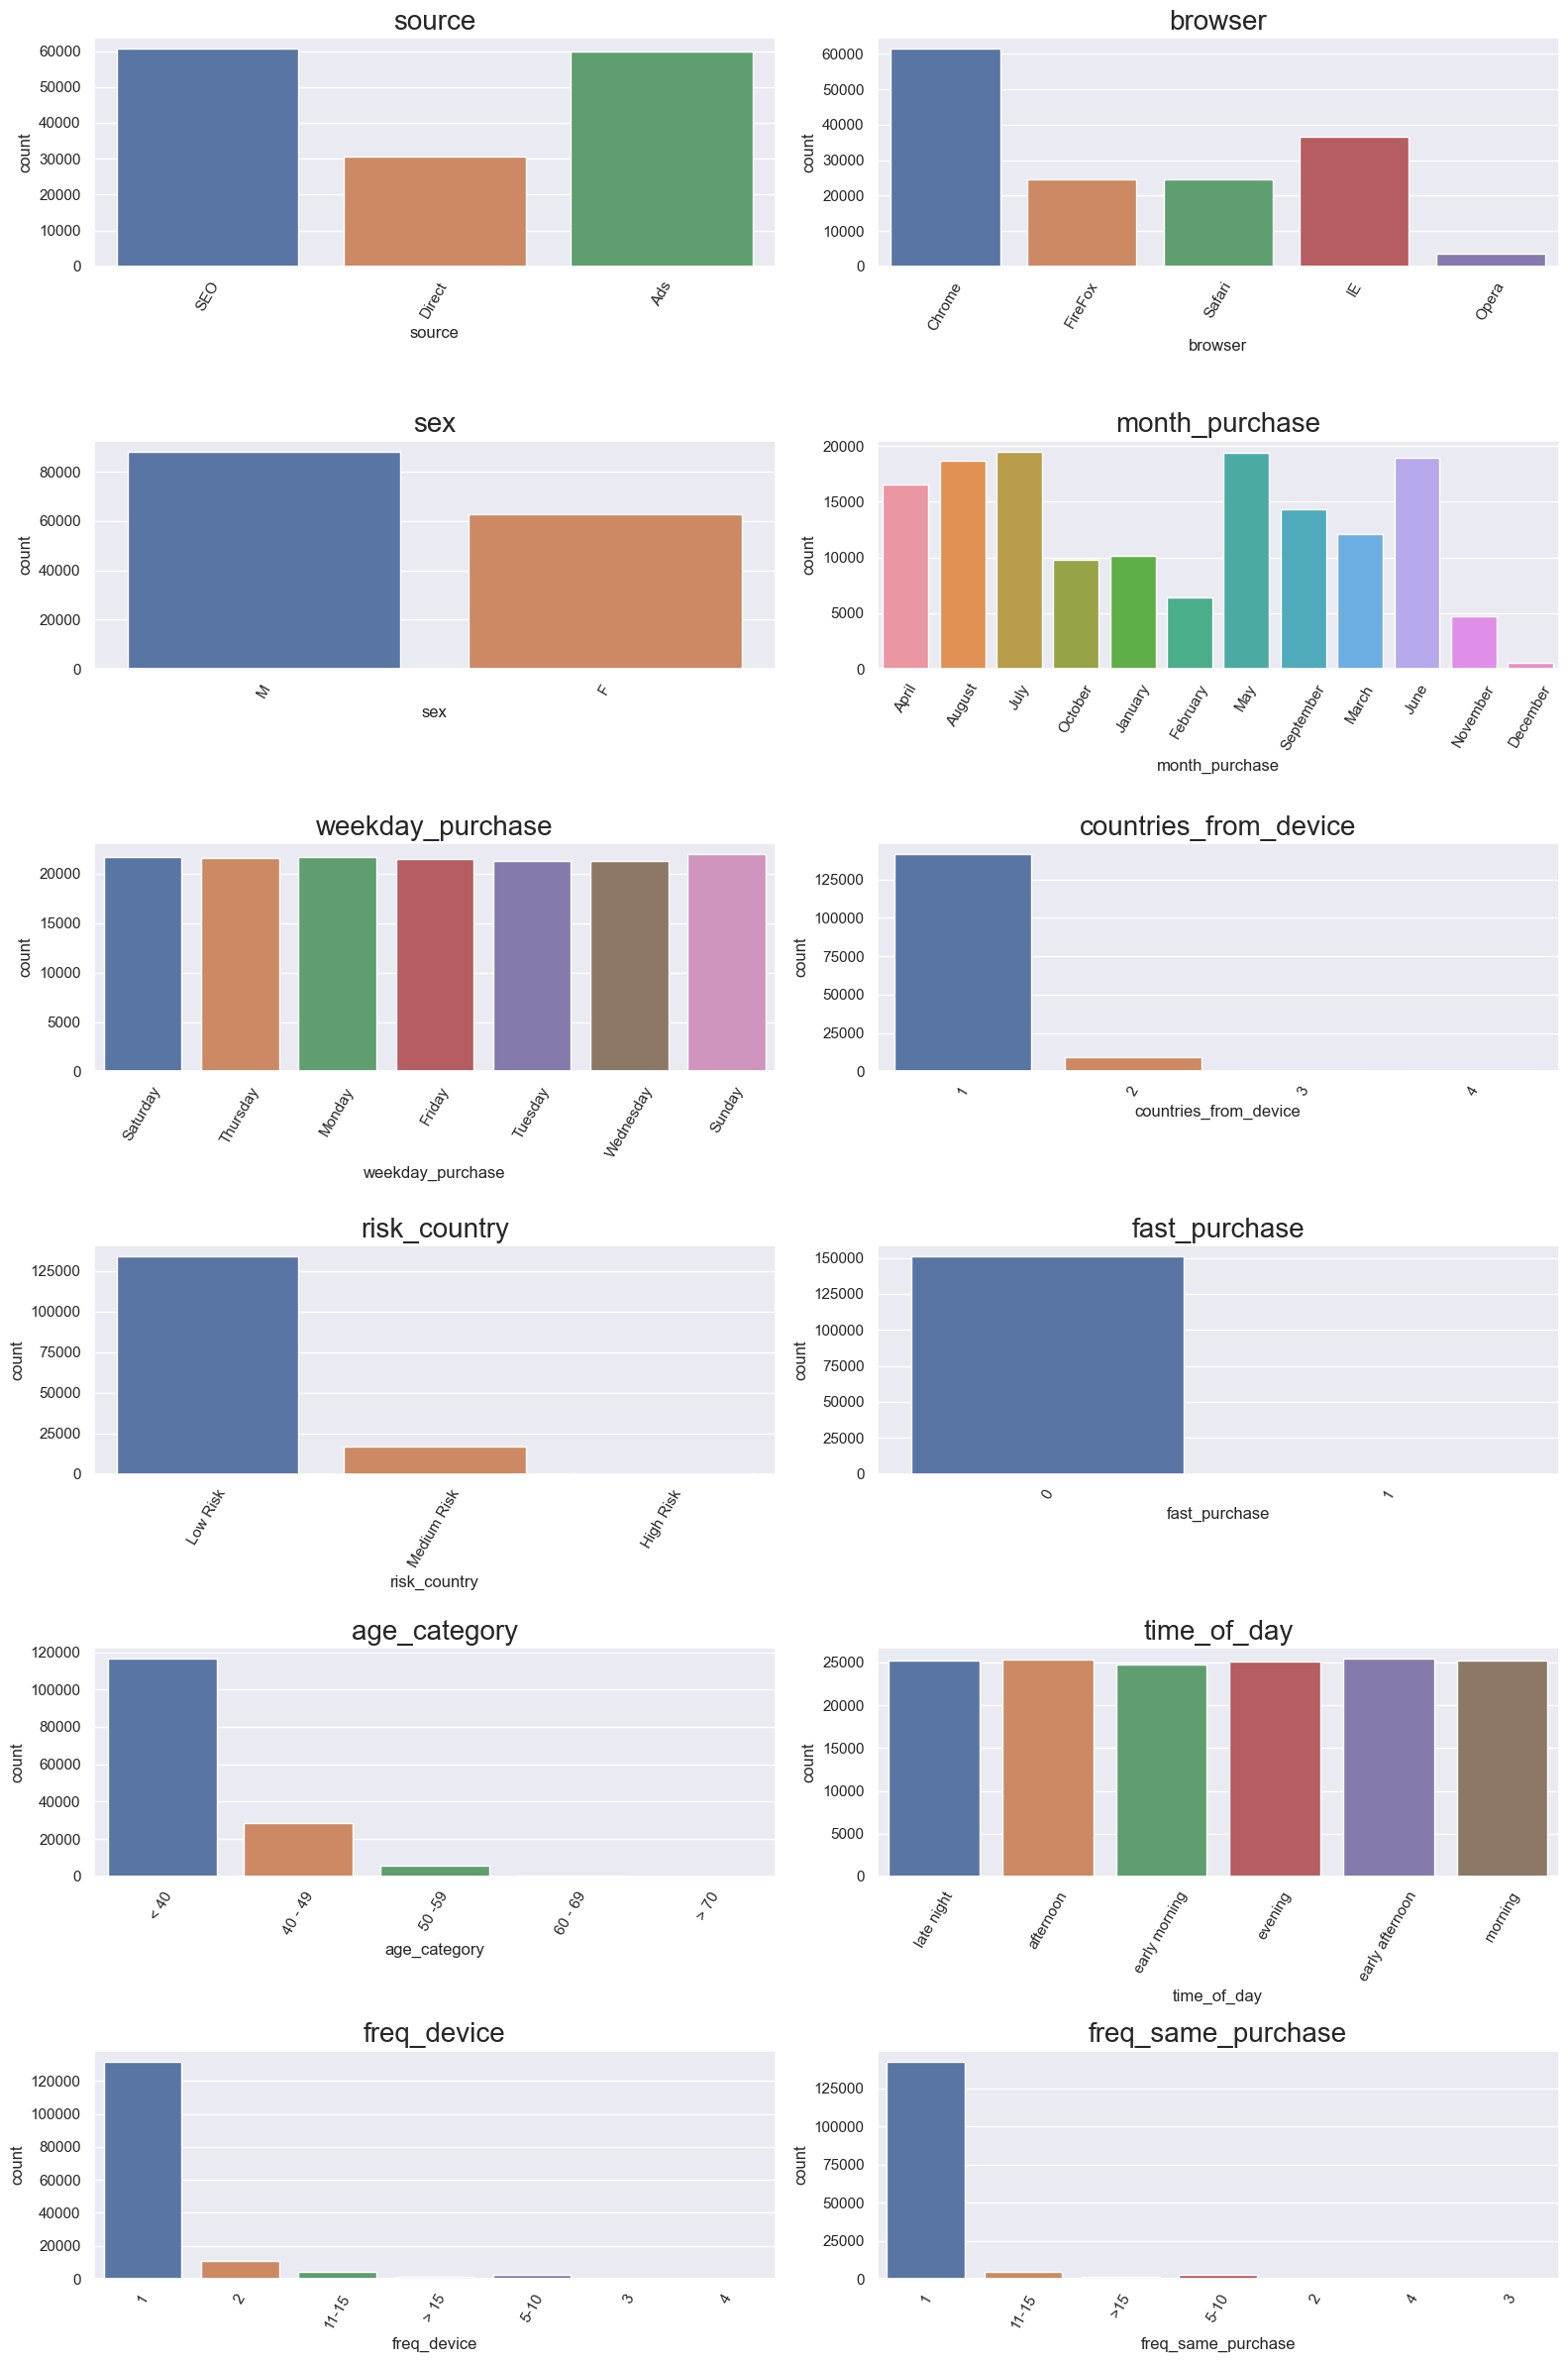

In [174]:
cat_variables = dataset[['source', 'browser', 'sex',
 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'fast_purchase', 'age_category', 'time_of_day', 'freq_device', 'freq_same_purchase']]

f, axes = plt.subplots(6, 2, figsize=(16, 24), sharex=False)
# sns.despine(left=True)

for index, name in enumerate(cat_variables):
    sns.countplot(x=name, data=dataset, ax=axes[index//2,index%2])
    axes[index//2,index%2].set_title(name, fontsize=20)
    axes[index//2,index%2].set_xticklabels(axes[index//2,index%2].get_xticklabels(), rotation=60)
    
plt.tight_layout()

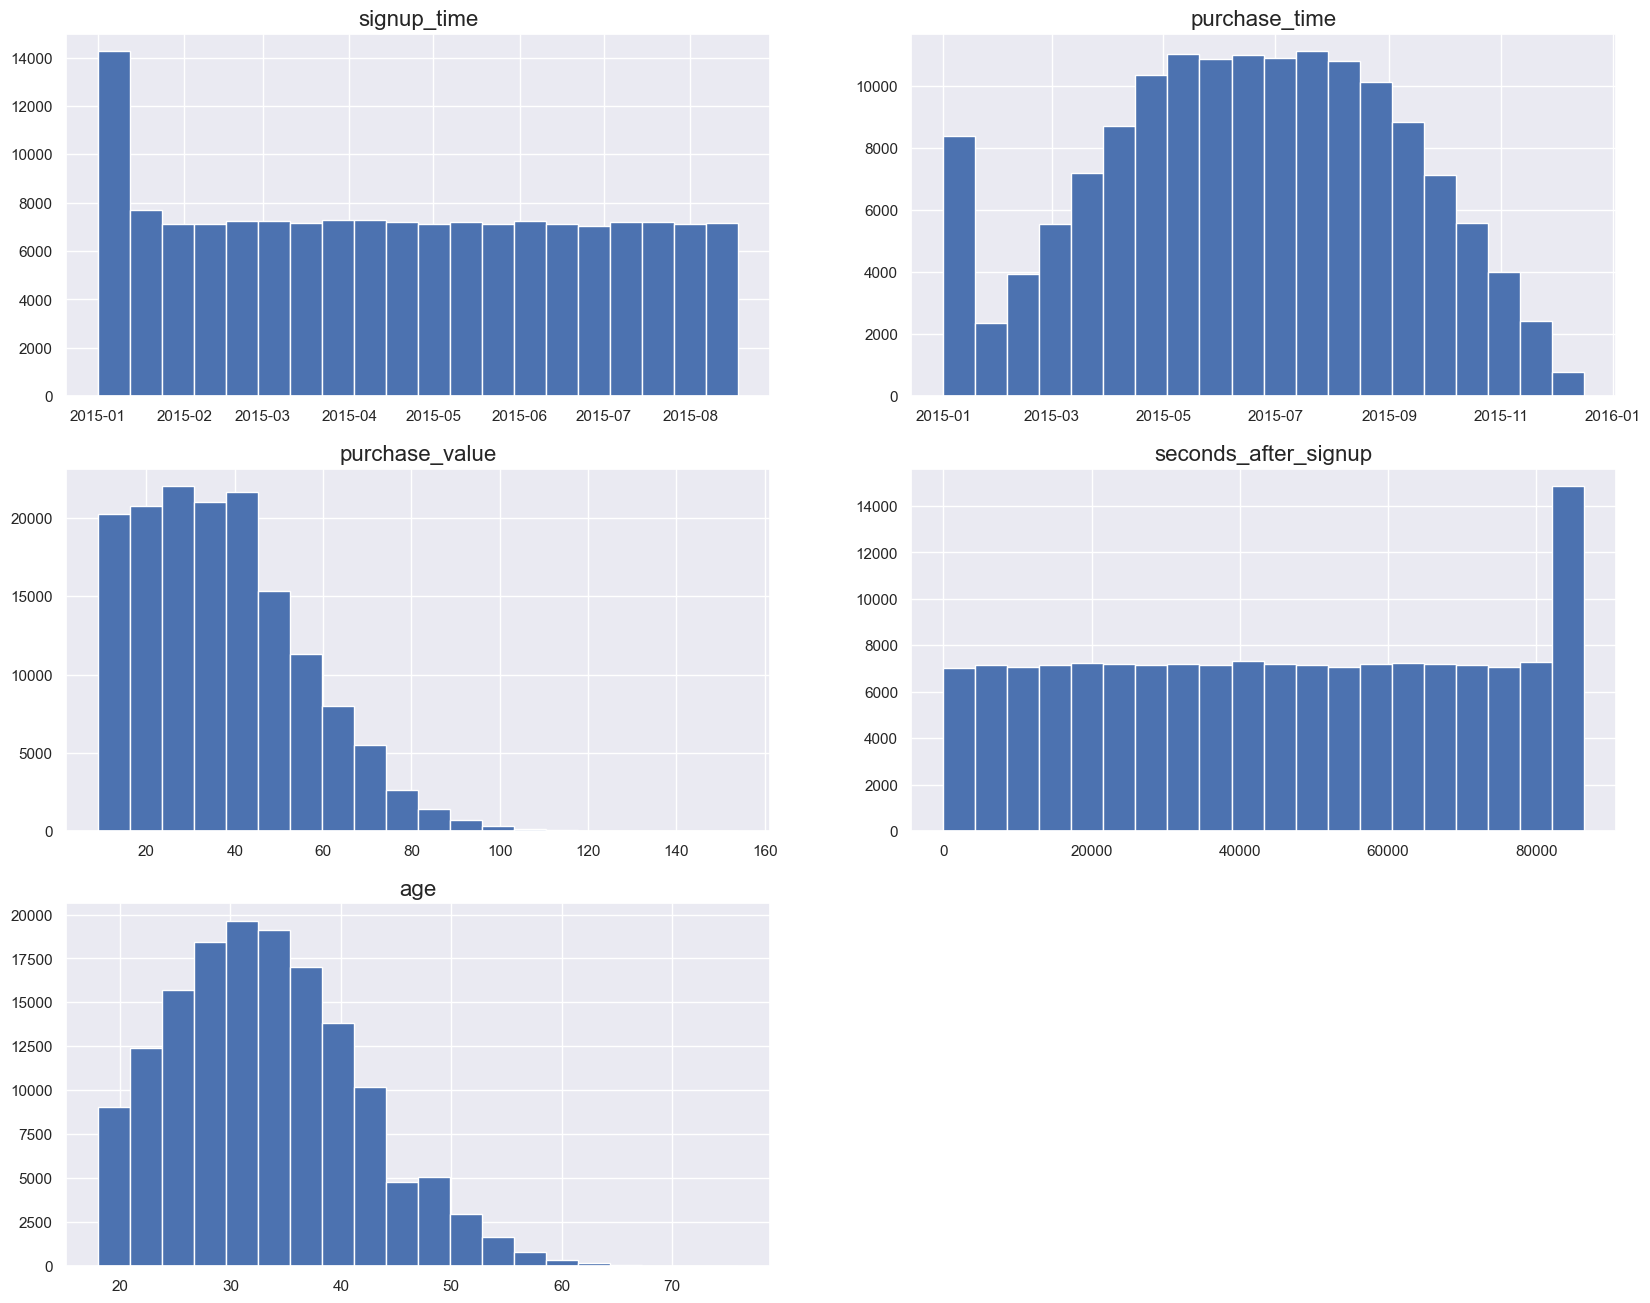

In [175]:
numerical_variables = ['signup_time', 'purchase_time', 'purchase_value', 'seconds_after_signup', 'age']
plt.figure(figsize=(20,16))
plt.subplot(321)

axes = [None] * len(numerical_variables)

for index, name in enumerate(dataset[numerical_variables].columns):
    axes[index] = plt.subplot(3, 2, index+1, label=str(index))
    dataset[name].hist(ax=axes[index], bins=20)
    axes[index].set_title(name, fontsize=16)

## Check for correlation between risk_country v all countries

remove all countries since they are correlated with risk_country. Verified with chi2 contingency

In [176]:
datasetCR = dataset[['IP_country', 'risk_country']].groupby(['IP_country', 'risk_country']).size()
datasetCR

IP_country             risk_country
Afghanistan            Medium Risk       6
Albania                Low Risk         13
Algeria                Medium Risk     122
Angola                 Low Risk         24
Antigua and Barbuda    Low Risk          3
                                      ... 
Viet Nam               Low Risk        550
Virgin Islands (U.S.)  High Risk         3
Yemen                  Low Risk          1
Zambia                 Low Risk         10
Zimbabwe               Low Risk          6
Length: 182, dtype: int64

In [177]:
datasetCR = datasetCR.unstack().fillna(0)
datasetCR = datasetCR.transpose() 
datasetCR

IP_country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,Bahamas,Bahrain,Bangladesh,Barbados,Belarus,Belgium,Belize,Benin,Bermuda,Bhutan,Bolivia,Bonaire; Sint Eustatius; Saba,Bosnia and Herzegowina,Botswana,Brazil,British Indian Ocean Territory,Brunei Darussalam,Bulgaria,Burkina Faso,Burundi,Cambodia,Cameroon,Canada,Cape Verde,Cayman Islands,Chile,China,Colombia,Congo,Congo The Democratic Republic of The,Costa Rica,Cote D'ivoire,Croatia (LOCAL Name: Hrvatska),Cuba,Curacao,Cyprus,Czech Republic,Denmark,Djibouti,Dominica,Dominican Republic,Ecuador,Egypt,El Salvador,Estonia,Ethiopia,European Union,Faroe Islands,Fiji,Finland,France,Gabon,Gambia,Georgia,Germany,Ghana,Gibraltar,Greece,Guadeloupe,Guam,Guatemala,Haiti,Honduras,Hong Kong,Hungary,Iceland,India,Indonesia,Iran (ISLAMIC Republic Of),Iraq,Ireland,Israel,Italy,Jamaica,Japan,Jordan,Kazakhstan,Kenya,Korea Republic of,Kuwait,Kyrgyzstan,Lao People's Democratic Republic,Latvia,Lebanon,Lesotho,Libyan Arab Jamahiriya,Liechtenstein,Lithuania,Luxembourg,Macau,Macedonia,Madagascar,Malawi,Malaysia,Maldives,Malta,Mauritius,Mexico,Moldova Republic of,Monaco,Mongolia,Montenegro,Morocco,Mozambique,Myanmar,Namibia,Nauru,Nepal,Netherlands,New Caledonia,New Zealand,Nicaragua,Niger,Nigeria,Norway,Oman,Pakistan,Palestinian Territory Occupied,Panama,Papua New Guinea,Paraguay,Peru,Philippines,Poland,Portugal,Puerto Rico,Qatar,Reunion,Romania,Russian Federation,Rwanda,Saint Kitts and Nevis,Saint Martin,San Marino,Saudi Arabia,Senegal,Serbia,Seychelles,Singapore,Slovakia (SLOVAK Republic),Slovenia,South Africa,South Sudan,Spain,Sri Lanka,Sudan,Sweden,Switzerland,Syrian Arab Republic,Taiwan; Republic of China (ROC),Tajikistan,Tanzania United Republic of,Thailand,Trinidad and Tobago,Tunisia,Turkey,Turkmenistan,Uganda,Ukraine,United Arab Emirates,United Kingdom,United States,Unknown,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
risk_country,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
High Risk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,106.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,72.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,119.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
Low Risk,0.0,13.0,0.0,24.0,3.0,661.0,0.0,1844.0,435.0,23.0,4.0,14.0,37.0,9.0,72.0,0.0,7.0,2.0,2.0,2.0,0.0,1.0,30.0,3.0,2961.0,1.0,7.0,166.0,2.0,1.0,15.0,5.0,0.0,1.0,4.0,0.0,12038.0,602.0,3.0,3.0,0.0,0.0,79.0,9.0,3.0,43.0,349.0,0.0,3.0,1.0,51.0,0.0,0.0,25.0,42.0,4.0,238.0,3.0,2.0,460.0,3161.0,9.0,1.0,32.0,3646.0,11.0,2.0,0.0,1.0,7.0,20.0,4.0,0.0,0.0,211.0,0.0,0.0,649.0,0.0,20.0,0.0,272.0,1944.0,7.0,7306.0,28.0,92.0,93.0,4162.0,0.0,18.0,4.0,64.0,0.0,2.0,14.0,2.0,0.0,0.0,10.0,24.0,1.0,0.0,210.0,2.0,0.0,17.0,0.0,37.0,3.0,6.0,0.0,158.0,16.0,1.0,0.0,1.0,18.0,1680.0,5.0,0.0,16.0,1.0,67.0,0.0,41.0,186.0,16.0,62.0,4.0,35.0,0.0,177.0,729.0,229.0,30.0,25.0,3.0,525.0,1616.0,15.0,2.0,1.0,1.0,0.0,0.0,69.0,0.0,208.0,86.0,87.0,838.0,1.0,1027.0,0.0,25.0,0.0,785.0,24.0,1237.0,1.0,15.0,291.0,22.0,0.0,568.0,0.0,13.0,0.0,0.0,0.0,58049.0,21966.0,80.0,0.0,1.0,0.0,550.0,0.0,1.0,10.0,6.0
Medium Risk,6.0,0.0,122.0,0.0,0.0,0.0,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,409.0,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2975.0,0.0,0.0,417.0,0.0,0.0,0.0,0.0,90.0,6.0,0.0,

<AxesSubplot:xlabel='IP_country', ylabel='risk_country'>

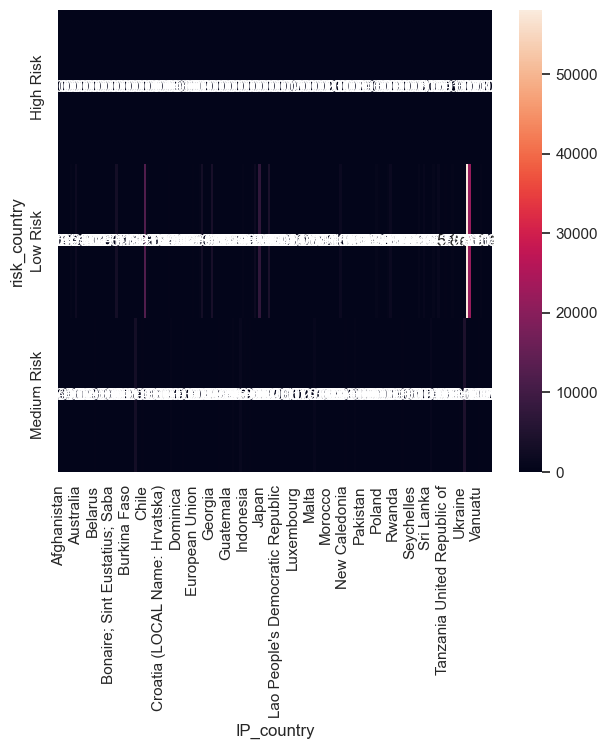

In [178]:
sns.heatmap(datasetCR, annot=True)

In [179]:
dataset.risk_country.unique()

array(['Low Risk', 'Medium Risk', 'High Risk'], dtype=object)

In [180]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(datasetCR) 
# Print the p-value
print("p value\t\t\t", p)

print("Chi2 Contingency\t", c)

p value			 0.0
Chi2 Contingency	 302224.00000000006


## Check for correlated variables with various numerical variables as dependent variable

In [181]:
model = ols('purchase_value ~ age_category + ip_address + seconds_after_signup + hour_of_the_day + month_purchase + weekday_purchase + risk_country + time_of_day + sex + fast_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.860848e+03,465.211876,1.385896,0.235931
month_purchase,11.0,5.592780e+03,508.434589,1.514659,0.118316
weekday_purchase,6.0,3.353721e+03,558.953496,1.665158,0.125042
risk_country,2.0,6.205795e+02,310.289751,0.924373,0.396782
time_of_day,5.0,5.613611e+03,1122.722211,3.344661,0.005057
sex,1.0,1.944080e+02,194.408030,0.579154,0.446645
fast_purchase,1.0,7.390126e+02,739.012586,2.201566,0.137873
ip_address,1.0,1.317803e+00,1.317803,0.003926,0.950040
seconds_after_signup,1.0,2.582479e+02,258.247887,0.769337,0.380424
hour_of_the_day,1.0,4.698747e+01,46.987467,0.139979,0.708303


In [182]:
model = ols('seconds_after_signup ~ age_category + ip_address + purchase_value + hour_of_the_day + month_purchase + weekday_purchase + risk_country + time_of_day + sex + fast_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.472293e+09,3.680731e+08,0.601244,6.617289e-01
month_purchase,11.0,9.960276e+12,9.054796e+11,1479.091908,0.000000e+00
weekday_purchase,6.0,2.689216e+09,4.482026e+08,0.732134,6.236791e-01
risk_country,2.0,1.520098e+09,7.600492e+08,1.241533,2.889439e-01
time_of_day,5.0,1.099687e+09,2.199373e+08,0.359265,8.765467e-01
sex,1.0,1.554648e+08,1.554648e+08,0.253950,6.143080e-01
fast_purchase,1.0,8.507720e+10,8.507720e+10,138.972752,4.612380e-32
ip_address,1.0,9.213896e+08,9.213896e+08,1.505081,2.198932e-01
purchase_value,1.0,4.709775e+08,4.709775e+08,0.769337,3.804236e-01
hour_of_the_day,1.0,9.701305e+07,9.701305e+07,0.158470,6.905698e-01


## Feature Selection

### XGBoost


In [183]:
cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex',
 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'fast_purchase', 'age_category', 'time_of_day', 'freq_device', 'freq_same_purchase']])

numerical_variables = dataset[['purchase_value', 'seconds_after_signup', 'age']]


dataset_2 = pd.concat([cat_encoded, numerical_variables], axis = 1)

In [184]:
# cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex', 'month_purchase', 'weekday_purchase',
#         'countries_from_device',
#        'risk_country', 'quick_purchase', 'age_category', 'period_of_the_day', 'freq_same_purchase']])
# numerical = dataset[['purchase_value', 'seconds_since_signup']] # Removed age

# dataset = pd.concat([cat_encoded, numerical], axis = 1)

#dont delete first


In [185]:
X = dataset_2
y = dataset[['class']]

In [186]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [187]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

In [188]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

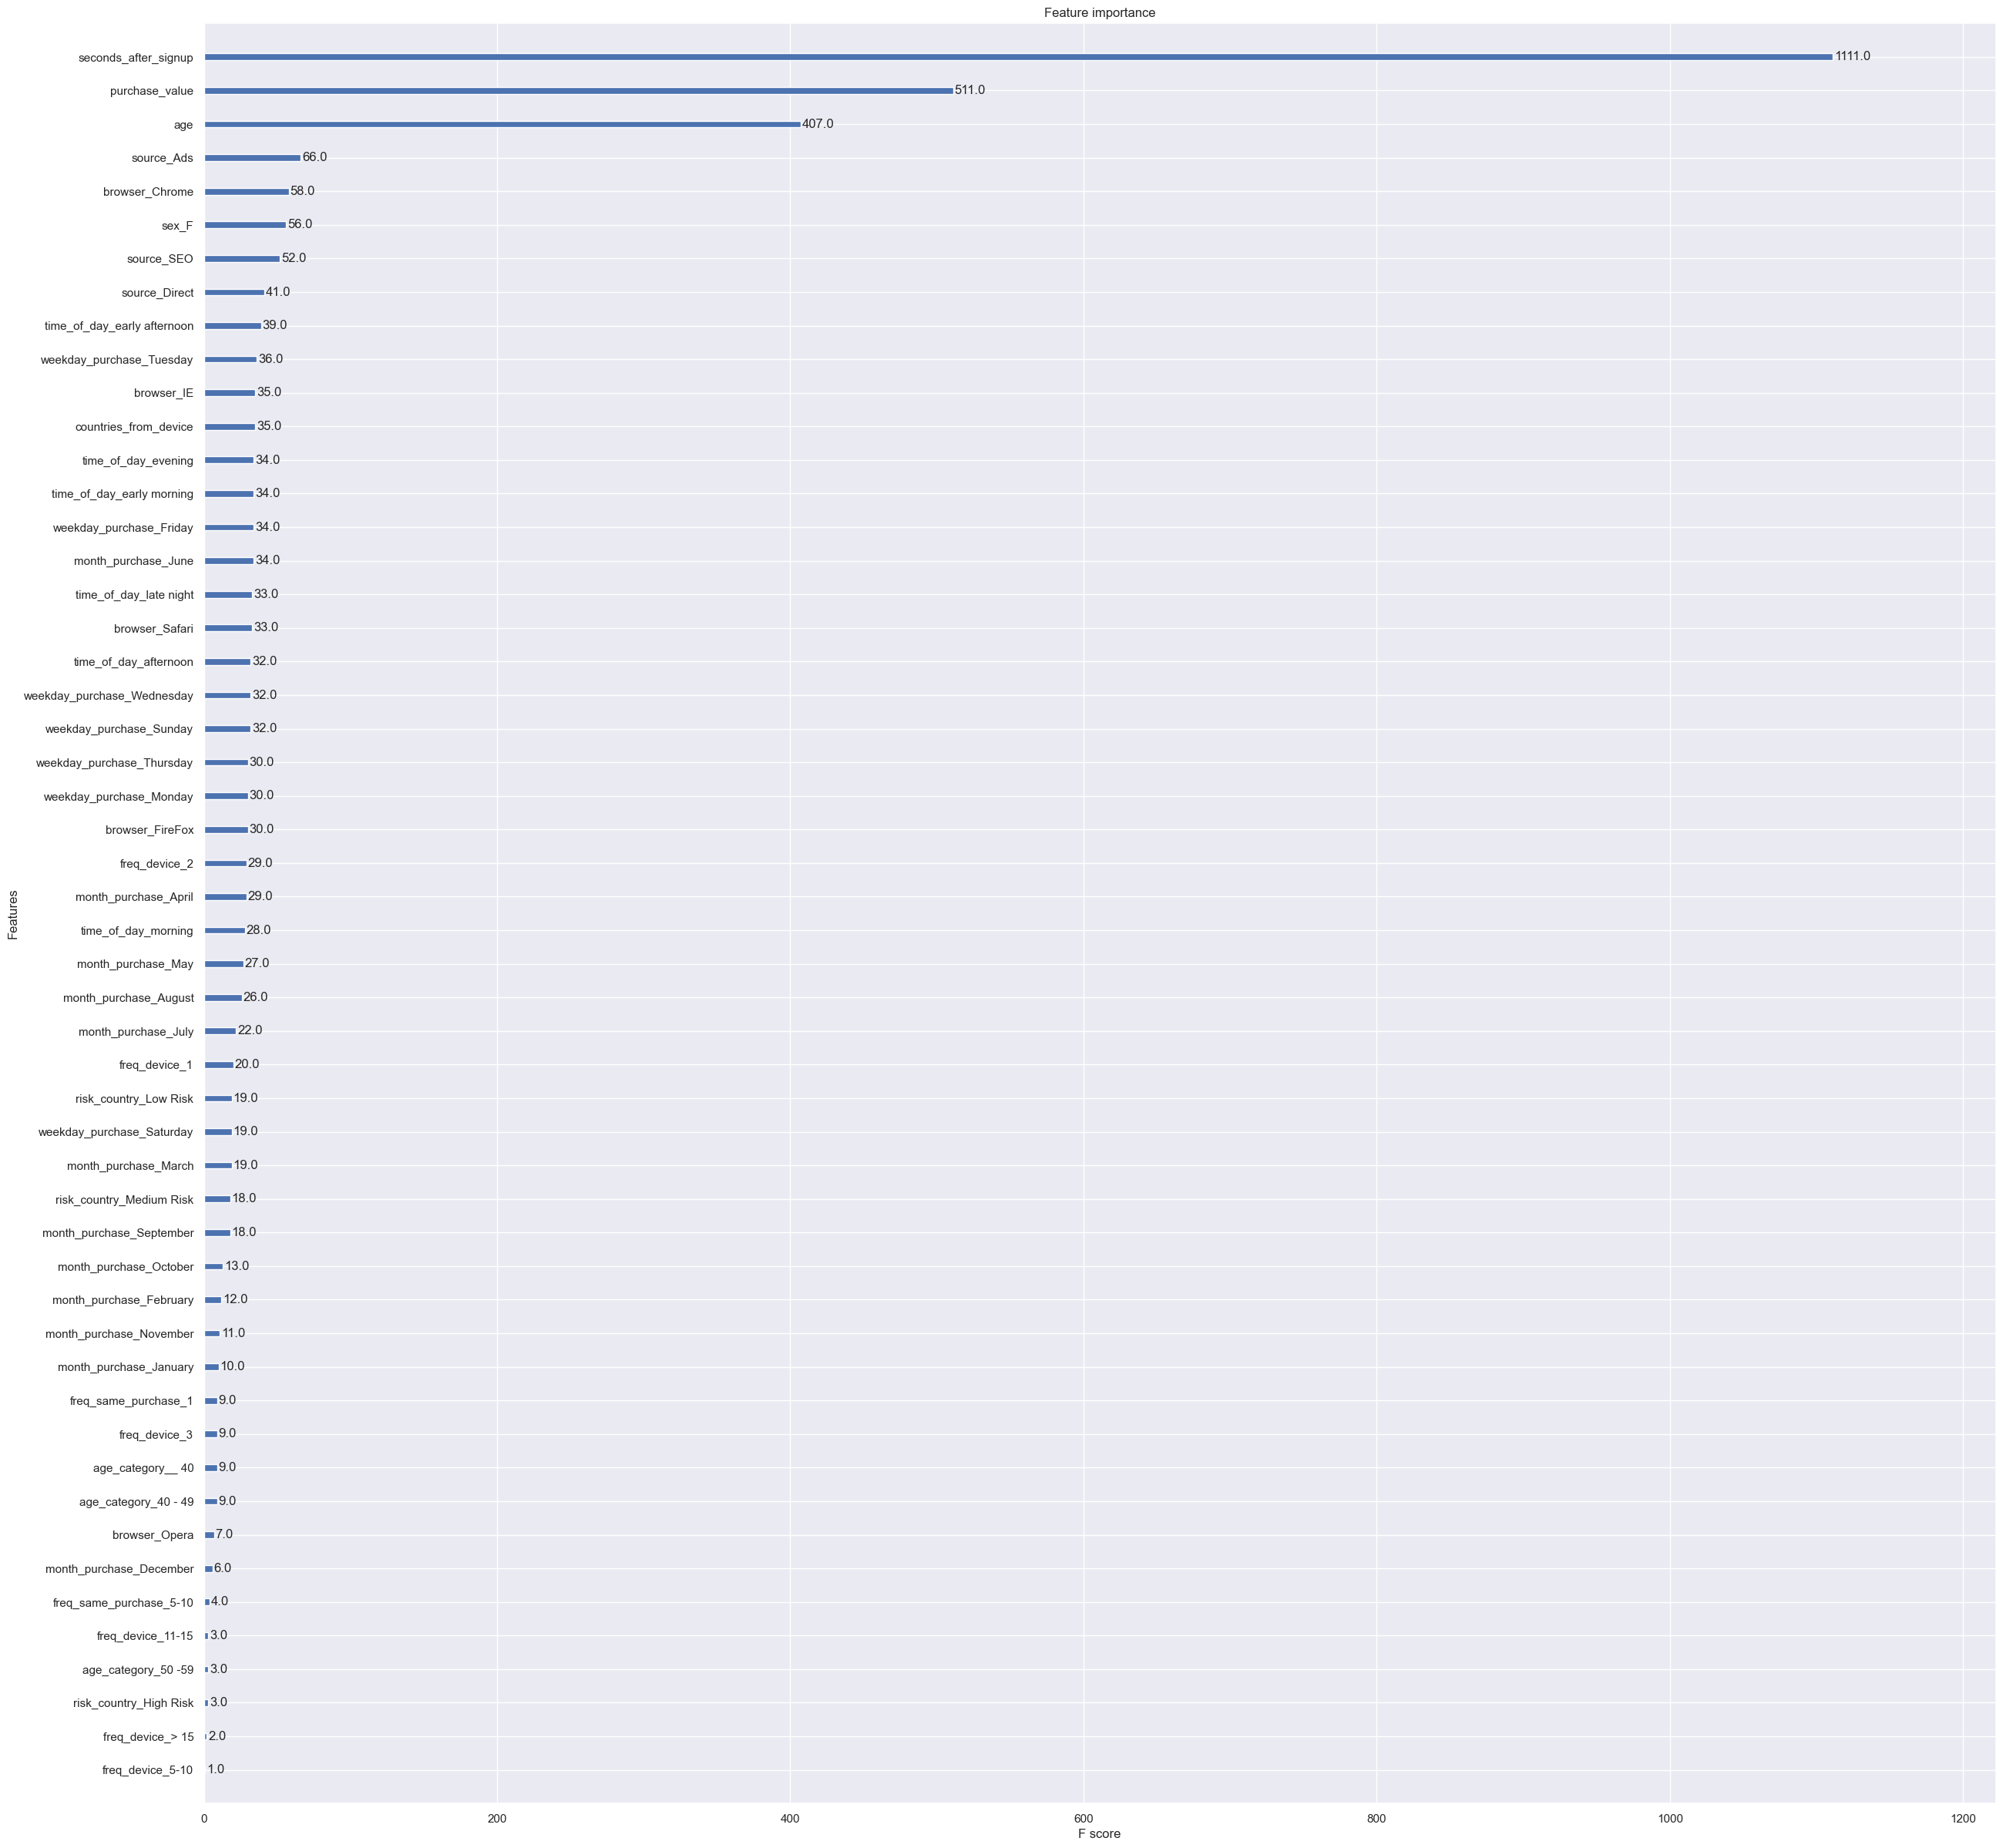

In [189]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.rcParams['figure.figsize'] = [30, 30]
display(plot_importance(model))

### RFE

In [190]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=13, step=1)
selector = selector.fit(X_train, y_train)

selector.ranking_


array([25, 11,  1, 23,  1,  8,  3, 26, 18,  9,  1, 20, 17, 34, 22, 28, 14,
       15,  7,  1, 24, 21, 16,  2,  6, 12, 19,  1, 10,  1, 35, 32, 30, 50,
       49, 43, 27, 33, 46, 29,  5,  4,  1, 13,  1,  1, 44, 38,  1, 36, 47,
       37, 48, 31, 41, 45, 40, 39, 42, 51,  1,  1,  1])

In [191]:
ranking = pd.DataFrame([ 1, 41, 18, 19, 23,  1,  5,  1, 26,  1, 15,  1,  8, 25, 36, 22, 29,
        4,  1, 16,  9, 27, 17, 11,  1, 20,  2, 10, 14,  1,  7, 32, 38, 35,
       37, 44, 21, 28, 39, 24,  1, 12, 13,  3,  1,  6, 30, 31, 43, 40, 33,
       34, 42,  1,  1,  1], columns=["ranking"])
features = pd.DataFrame(['countries_from_device', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'month_purchase_April',
       'month_purchase_August', 'month_purchase_December',
       'month_purchase_February', 'month_purchase_January',
       'month_purchase_July', 'month_purchase_June', 'month_purchase_March',
       'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High Risk',
       'risk_country_Low Risk', 'risk_country_Medium Risk', 'fast_purchase_0',
       'fast_purchase_1', 'age_category_ > 70', 'age_category_40 - 49',
       'age_category_50 -59', 'age_category_60 - 69', 'age_category__ 40',
       'time_of_day_afternoon', 'time_of_day_early afternoon',
       'time_of_day_early morning', 'time_of_day_evening',
       'time_of_day_late night', 'time_of_day_morning', 'freq_device_1',
       'freq_device_11-15', 'freq_device_2', 'freq_device_3',
       'freq_device_4', 'freq_device_5-10', 'freq_device_> 15',
       'freq_same_purchase_1', 'freq_same_purchase_2',
       'freq_same_purchase_3', 'freq_same_purchase_4',
       'freq_same_purchase_11-15', 'freq_same_purchase_5-10',
       'freq_same_purchase_>15', 'purchase_value', 'seconds', 'age'], columns = ['features'])
feat_df = pd.concat([ranking, features], axis = 1)

In [192]:
rslt_df = feat_df.loc[feat_df['ranking'] == 1]

In [193]:
rslt_df

,ranking,features
0,1.0,countries_from_device
5,1.0,browser_FireFox
7,1.0,browser_Opera
9,1.0,sex_F
11,1.0,month_purchase_April
18,1.0,month_purchase_March
24,1.0,weekday_purchase_Monday
29,1.0,weekday_purchase_Wednesday
40,1.0,time_of_day_afternoon
44,1.0,time_of_day_late night


## Reading Final DataFrames, i.e. those that were upsampled

## Select the relevant columns for building the model

Take from XGBoost section for Train Test Split, the codes now also have upsampled dataset

In [258]:
final_df_X = dataset_2[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_after_signup']]


In [259]:
final_df_y = dataset[['class']]

In [260]:
X_train, X_test, y_train, y_test = train_test_split(
   final_df_X, final_df_y, test_size=0.30, random_state=42)

In [261]:
train_df = pd.concat([X_train, y_train], axis=1)

In [262]:
from sklearn.utils import resample

not_fraud = train_df[train_df['class']==0]
fraud = train_df[train_df['class']==1]
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['class'].value_counts()

0    95888
1    95888
Name: class, dtype: int64

In [263]:
final_x_train = upsampled[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_after_signup']]



Index(['countries_from_device', 'source_Ads', 'source_Direct', 'source_SEO',
       'browser_Chrome', 'browser_FireFox', 'browser_IE', 'browser_Opera',
       'browser_Safari', 'sex_F', 'sex_M', 'month_purchase_April',
       'month_purchase_August', 'month_purchase_December',
       'month_purchase_February', 'month_purchase_January',
       'month_purchase_July', 'month_purchase_June', 'month_purchase_March',
       'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High Risk',
       'risk_country_Low Risk', 'risk_country_Medium Risk', 'fast_purchase_0',
       'fast_purchase_1', 'age_category_ > 70', 'age_category_40 - 49',
       'age_category_50 -59', 'age_category_60 - 69', 'age_categor

In [264]:
final_y_train = upsampled[['class']]

In [265]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() 
stand = scaler.fit(final_x_train)
x_scaled_train = stand.transform(final_x_train)
x_scaled_test = stand.transform(X_test)
print(pd.DataFrame(x_scaled_train).describe())
print(pd.DataFrame(x_scaled_test).describe())

                 0             1             2             3             4   \
count  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05   
mean  -9.070002e-17  4.779535e-18  8.069634e-17  3.460532e-17 -9.677632e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00  1.000003e+00   
min   -3.532025e-01 -8.037529e-01 -5.246675e-01 -8.024001e-01 -8.465360e-01   
25%   -3.532025e-01 -8.037529e-01 -5.246675e-01 -8.024001e-01 -8.465360e-01   
50%   -3.532025e-01 -8.037529e-01 -5.246675e-01 -8.024001e-01 -8.465360e-01   
75%   -3.532025e-01  1.244163e+00 -5.246675e-01  1.246261e+00  1.181285e+00   
max    8.884332e+00  1.244163e+00  1.905969e+00  1.246261e+00  1.181285e+00   

                 5             6             7             8             9   \
count  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05  1.917760e+05   
mean  -7.002575e-18  1.237863e-16 -3.215997e-17 -1.085955e-16 -6.402354e-17   
std    1.000003e+00  1.000003e+00  1.000003e+00  1.

## Random Forest Classifer Before Upsampling

In [202]:
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rfc.fit(X_train, y_train)

rfc.decision_path(X_train)

C:\Users\J\AppData\Local\Temp\ipykernel_2528\1880976047.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


(<105778x1435024 sparse matrix of type '<class 'numpy.int64'>'
 	with 212925823 stored elements in Compressed Sparse Row format>,
 array([      0,   14069,   28074,   42395,   56516,   70611,   84738,
          99237,  113926,  129233,  143656,  157883,  172510,  186579,
         200390,  214693,  228558,  242953,  257098,  271699,  286854,
         301009,  315614,  329759,  344052,  358199,  372506,  386963,
         401850,  415579,  430072,  445025,  459354,  473779,  488118,
         502427,  517014,  531539,  545846,  559937,  573998,  589021,
         603432,  617543,  631296,  645487,  659352,  673863,  688590,
         702783,  717402,  731741,  745708,  760235,  774662,  788951,
         803504,  817393,  831590,  845721,  860478,  874887,  889440,
         904325,  918184,  932855,  947610,  961991,  976614,  990887,
        1004764, 1018975, 1033100, 1047265, 1061964, 1076623, 1090758,
        1104987, 1119282, 1133127, 1147240, 1161447, 1175904, 1190227,
        1204610, 1

In [203]:
y_pred = rfc.predict(X_test)

from sklearn import metrics 

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9492654519786474


In [204]:
## Other metrics

print("precision score OF THE MODEL: ", metrics.precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", metrics.recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", metrics.f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", metrics.roc_auc_score(y_test, y_pred))

precision score OF THE MODEL:  0.8595526219288595
recall score OF THE MODEL:  0.550105609011969
f1 score OF THE MODEL:  0.6708643388666284
ROC AUC score OF THE MODEL:  0.7703903741989702


## Random Forest Classifier After Upsampling

In [205]:
# rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy")

# rfc.fit(X_train_upsampled, y_train_upsampled)

# rfc.decision_path(X_train_upsampled)

In [206]:
# y_pred = rfc.predict(X_test)

# from sklearn import metrics 

# # using metrics module for accuracy, precision, recall, f1 and ROC AUC calculation
# print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
# print("precision score OF THE MODEL: ", metrics.precision_score(y_test, y_pred))
# print("recall score OF THE MODEL: ", metrics.recall_score(y_test, y_pred))
# print("f1 score OF THE MODEL: ", metrics.f1_score(y_test, y_pred))
# print("ROC AUC score OF THE MODEL: ", metrics.roc_auc_score(y_test, y_pred))

## Logistic Regression

### Correlation Checking

In [207]:
cat_vars = [
    'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_Safari', 'sex_F', 'weekday_purchase_Thursday', 'age_category_ > 70', 
    'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69','age_category_< 40', 'time_of_day_afternoon',
    ]
    
num_vars = ['countries_from_device', 'purchase_value', 'seconds_after_signup']

features_selected = ['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'time_of_day_afternoon',
        'purchase_value', 'seconds_after_signup']

#### Chi Square Test (Categorical vs Catergorical)

In [208]:
p_values = []
chai_stats = []
for cat1 in cat_vars:
    for cat2 in cat_vars:
            crosstab = pd.crosstab(dataset_2[cat1], dataset_2[cat2])
            chai2, p_val, _, _ = chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))

chisquare = pd.DataFrame(p_values, columns=['Categorical 1', 'Categorical 2', 'p-value'])
chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value')

Categorical 2,age_category_ > 70,age_category_40 - 49,age_category_50 -59,age_category_60 - 69,age_category_< 40,browser_Chrome,browser_Safari,sex_F,source_Ads,source_Direct,source_SEO,time_of_day_afternoon,weekday_purchase_Thursday
Categorical 1,,,,,,,,,,,,,
age_category_ > 70,0.000000e+00,3.029295e-01,1.000000e+00,1.000000e+00,3.417567e-07,0.914181,1.000000,1.000000,0.963895,0.164399,0.450235,0.376163,0.454209
age_category_40 - 49,3.029295e-01,0.000000e+00,7.633076e-295,5.064812e-22,0.000000e+00,0.791410,0.815478,0.202494,0.095534,0.384235,0.017138,0.581859,0.308847
age_category_50 -59,1.000000e+00,7.633076e-295,0.000000e+00,1.648559e-04,0.000000e+00,0.274124,0.029245,0.638514,0.048215,1.000000,0.048077,0.316238,0.048300
age_category_60 - 69,1.000000e+00,5.064812e-22,1.648559e-04,0.000000e+00,1.275374e-293,0.408254,0.166818,0.936471,0.183552,1.000000,0.185871,0.741492,0.362758
age_category_< 40,3.417567e-07,0.000000e+00,0.000000e+00,1.275374e-293,0.000000e+00,0.391709,0.359618,0.156141,0.406629,0.399899,0.127329,0.895348,0.052721
browser_Chrome,9.141806e-01,7.914103e-01,2.741243e-01,4.082544e-01,3.917085e-01,0.000000,0.000000,0.835759,0.715044,0.000276,0.008988,0.437667,0.368526
browser_Safari,1.000000e+00,8.154776e-01,2.924522e-02,1.668185e-01,3.596182e-01,0.000000,0.000000,0.523753,0.719170,0.046143,0.045368,0.189722,0.023199
sex_F,1.000000e+00,2.024941e-01,6.385143e-01,9.364713e-01,1.561406e-01,0.835759,0.523753,0.000000,0.938092,0.498873,0.523850,0.549670,0.951839
source_Ads,9.638946e-01,9.553412e-02,4.821504e-02,1.835520e-01,4.066292e-01,0.715044,0.719170,0.938092,0.000000,0.000000,0.000000,0.894604,0.411521


Text(0.5, 1.0, 'Chi-Square Correlation Heatmap (Cat vs Cat)')

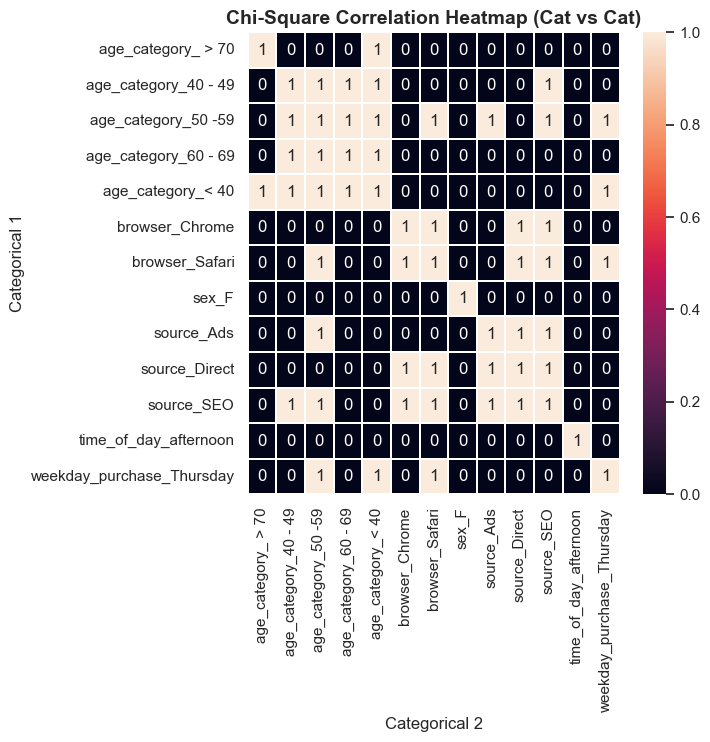

In [209]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
sns.heatmap(round(chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value'),2) <= 0.05,
                 annot=True, 
                 linewidths=.05)

plt.title('Chi-Square Correlation Heatmap (Cat vs Cat)', fontsize=14, fontweight='bold')

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for chi square test, 1 indicating the rejection of null hypothesis, the categorical variables are correlated between one another.

#### Pearson Correlation (Numerical vs Numerical)

Text(0.5, 1.0, 'Pearson Correlation Heatmap (Num vs Num)')

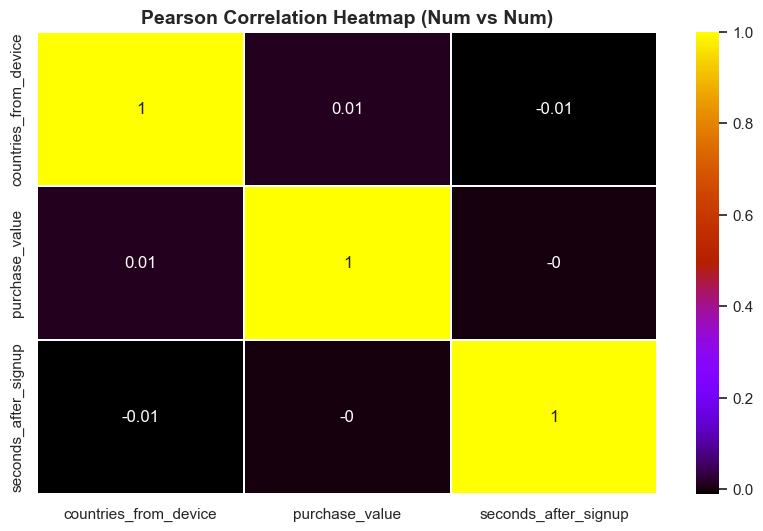

In [210]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
corrMatrix = dataset[num_vars].corr()
sns.heatmap(round(corrMatrix, 2), ax=ax,annot=True, cmap=cmap,linewidths=.05)

plt.title('Pearson Correlation Heatmap (Num vs Num)', fontsize=14, fontweight='bold')


From the correlation matrix, the numerical variables are not correlated to one another.

#### Anova Test (Numerical vs Categorical)

In [211]:
results = []

for cat in cat_vars:
    for num in num_vars:
        
        candidates = []
        for val in dataset_2[cat].unique():
            if len(dataset_2[dataset_2[cat]==val][num])>0:
                candidates.append(dataset_2[dataset_2[cat]==val][num])
                
        _, p_val = f_oneway(*candidates)
        results.append((cat, num, p_val))

In [212]:
anova = pd.DataFrame(results, columns=['Categorical', 'Numerical', 'P-value'])
anova.pivot_table(index='Numerical', columns='Categorical')

P-value                       \
Categorical           age_category_ > 70 age_category_40 - 49   
Numerical                                                       
countries_from_device           0.442735             0.549494   
purchase_value                  0.429586             0.031523   
seconds_after_signup            0.894500             0.896843   

                                                                \
Categorical           age_category_50 -59 age_category_60 - 69   
Numerical                                                        
countries_from_device            0.089754             0.936362   
purchase_value                   0.743723             0.826648   
seconds_after_signup             0.254368             0.350512   

                                                                       \
Categorical           age_category_< 40 browser_Chrome browser_Safari   
Numerical                                                               
countries_from_device          0.824131       0.844776       0.912697   
purchase_value                 0.034699       0.090500       0.427408   
seconds_after_signup           0.782591       0.045927       0.082801   

                                                                     \
Categorical               sex_F source_Ads source_Direct source_SEO   
Numerical                                                             
countries_from_device  0.551148   0.053254      0.281114   0.296028   
purchase_value         0.437897   0.864608      0.956089   0.900518   
seconds_after_signup   0.710436   0.274792      0.300312   0.809982   

                                                                       
Categorical           time_of_day_afternoon weekday_purchase_Thursday  
Numerical                                                              
countries_from_device              0.452470                  0.219103  
purchase_value                     0.581404                  0.032799  
seconds_after_signup               0.019772                  0.145332

Text(0.5, 1.0, 'Anova Test Correlation Heatmap (Num vs Cat)')

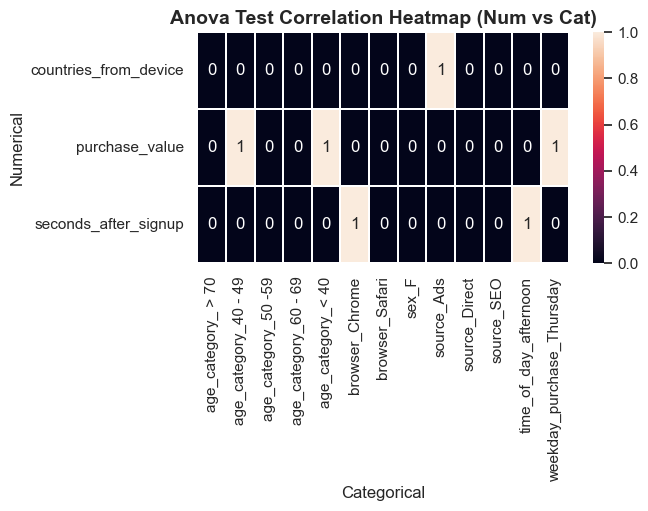

In [213]:
fig, ax = plt.subplots(1,1, figsize=(6,3))

sns.heatmap(round(anova.pivot_table(index='Numerical', columns='Categorical', values='P-value'),2) <= 0.05,
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 annot=True, 
                 linewidths=.05)

plt.title('Anova Test Correlation Heatmap (Num vs Cat)', fontsize=14, fontweight='bold')

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for anova test, 1 indicating the rejection of null hypothesis, all the numerical variables are correlated with some of the categorical variables.

`In conclusion, we noticed correlation between the features that we have selected, which we will take account of in the further stages.`

### Running of Logistic Regression Model

#### Tuning Hyperparameter (Penalty [Regularisation], C value [Regularisation Rate]) through Cross-Validation

In [214]:
# define models and parameters
model = LogisticRegression()
solvers = ['saga']
penalty = ['l1', 'l2']
# define grid search
grid = dict(solver=solvers,penalty=penalty)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(x_scaled_train, final_y_train['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in sorted(zip(means, stds, params), reverse=True):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.799963 using {'penalty': 'l1', 'solver': 'saga'}
0.799963 with: {'penalty': 'l1', 'solver': 'saga'}
0.799958 with: {'penalty': 'l2', 'solver': 'saga'}


In [215]:
# define models and parameters
model = LogisticRegression()
solvers = ['saga']
penalty = ['l2']
c_values = [1000, 100, 10, 1.0, 0.1, 0.01, 0.001]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(x_scaled_train, final_y_train['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in sorted(zip(means, stds, params), reverse=True):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.799959 using {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.799959 with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.799959 with: {'C': 1000, 'penalty': 'l2', 'solver': 'saga'}
0.799959 with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.799959 with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.799955 with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.799927 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
0.799650 with: {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}


#### Actual Running of Model

In [266]:
# define models and parameters
# model = LogisticRegression(solver='saga', penalty='l2', C=0.00001)
model = LogisticRegression()

# fit model
model.fit(x_scaled_train, final_y_train['class'])

# predict model
y_pred = model.predict(x_scaled_test)


In [267]:
# using metrics module for accuracy, precision, recall, f1 and ROC AUC calculation
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))
print("precision score OF THE MODEL: ", precision_score(y_test, y_pred))
print("recall score OF THE MODEL: ", recall_score(y_test, y_pred))
print("f1 score OF THE MODEL: ", f1_score(y_test, y_pred))
print("ROC AUC score OF THE MODEL: ", roc_auc_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9127586359024132
precision score OF THE MODEL:  0.5261717413616148
recall score OF THE MODEL:  0.7218962684815771
f1 score OF THE MODEL:  0.608687048580192
ROC AUC score OF THE MODEL:  0.827227685284053


In [268]:
print('Train R2:', r2(final_y_train, model.predict(x_scaled_train)))

print('Test R2:', r2(y_test, y_pred))

Train R2: 0.2961580176873019
Test R2: -0.024477839820552072


In [244]:
def efron_rsquare(y, y_pred):
    n = float(len(y))
    t1 = np.sum(np.power(y - y_pred, 2.0))
    t2 = np.sum(np.power((y - (np.sum(y) / n)), 2.0))
    return 1.0 - (t1 / t2)

efron_rsquare(y_test['class'], y_pred)

-2.7075477424403442

## Neural Network

In [146]:
import keras
import tensorflow
from keras.models import Sequential
from keras import layers
from keras.layers import BatchNormalization, Dropout

# number of hidden nodes
H = 100
# input dimension
input_dim = 1
# num of epochs
num_epochs = 100

# create sequential multi-layer perceptron
model1 = Sequential()

# layer 0
model1.add(keras.layers.Dense(units=H, input_shape=(16,), activation='relu')) 

model1.add(BatchNormalization())

model1.add(Dropout(0.2))

# layer 1
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 2
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 3
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 4
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 5
model1.add(keras.layers.Dense(units=H, activation='relu')) 

# layer 6 (output layer)
model1.add(keras.layers.Dense(units=1, activation='sigmoid')) 

# configure the model
model1.compile(loss='binary_crossentropy', optimizer='adam')

# fit the model 
model_history1 = model1.fit(x_scaled_train, final_y_train, batch_size=50, epochs=num_epochs, verbose=0)

In [147]:
train_score = model1.evaluate(x_scaled_train, final_y_train, verbose=0)
print('Train loss:', train_score)

test_score = model1.evaluate(x_scaled_test, y_test, verbose=0)
print('Test loss:', test_score)

Train loss: 0.37326058745384216
Test loss: 0.42247316241264343


In [148]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
predictions = (model1.predict(x_scaled_test)>0.5).astype('int32')
cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

1417/1417 [==============================] - 2s 1ms/step
True Positive(TP)  =  2921
False Positive(FP) =  3254
True Negative(TN)  =  37819
False Negative(FN) =  1340


In [149]:
print("accuracy: " + "{accuracy}".format(accuracy = metrics.accuracy_score(y_test,predictions)))
print("precision: " + "{precision}".format(precision =metrics.precision_score(y_test,predictions)))
print("recall: " + "{recall}".format(recall = metrics.recall_score(y_test,predictions)))
print("ROC AUC score OF THE MODEL: ", metrics.roc_auc_score(y_test, predictions))

accuracy: 0.8986632549521331
precision: 0.47303643724696354
recall: 0.6855198310255809
ROC AUC score OF THE MODEL:  0.8031475180740838
